In [3]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from netCDF4 import Dataset
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
path = os.getcwd()
import matplotlib

In [4]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(tf.__version__)
print(device_lib.list_local_devices())

2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6785877190202047566
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3667263488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2626857017106406203
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


* 데이터셋

In [5]:
# In[] SMOKE-CMAQ
# CMAQ 연평균 PM농도
pm2_5 = np.array([])

for i in range(1,120):
    a = 'ACONC.' + str(i)
    nc = Dataset(a, 'r')
    pm2_5 = np.append(pm2_5, np.array([[[nc.variables['PM2_5']]]]))
    
pm2_5 = np.reshape(pm2_5, [119,82,67])
pm2_5 = pm2_5[:,8:-10,2:-1]
pm2_5 = np.reshape(pm2_5, [119,64,64]) # convolution 연산을 위해

pm = pm2_5


y1 = np.array([])
y2 = np.array([])
y3 = np.array([])
y4 = np.array([])
y5 = np.array([])
y6 = np.array([])

for i in range(1,120):
    a = 'EMIS_AVG.' + str(i)
    nc = Dataset(a, 'r')
    y1 = np.append(y1, np.array([[[nc.variables['SO2']]]]))
    y2 = np.append(y2, np.array([[[nc.variables['PM2_5']]]]))
    y3 = np.append(y3, np.array([[[nc.variables['NOx']]]]))
    y4 = np.append(y4, np.array([[[nc.variables['VOCs']]]]))
    y5 = np.append(y5, np.array([[[nc.variables['NH3']]]]))
    y6 = np.append(y6, np.array([[[nc.variables['CO']]]]))
    
y1 = np.reshape(y1, [119,82,67])
y1 = y1[:,8:-10,2:-1]
y1 = np.reshape(y1, [119,64,64])
y1_max = np.max(y1)
y1_min = np.min(y1)

y2 = np.reshape(y2, [119,82,67])
y2 = y2[:,8:-10,2:-1]
y2 = np.reshape(y2, [119,64,64])
y2_max = np.max(y2)
y2_min = np.min(y2)

y3 = np.reshape(y3, [119,82,67])
y3 = y3[:,8:-10,2:-1]
y3 = np.reshape(y3, [119,64,64])
y3_max = np.max(y3)
y3_min = np.min(y3)

y4 = np.reshape(y4, [119,82,67])
y4 = y4[:,8:-10,2:-1]
y4 = np.reshape(y4, [119,64,64])
y4_max = np.max(y4)
y4_min = np.min(y4)

y5 = np.reshape(y5, [119,82,67])
y5 = y5[:,8:-10,2:-1]
y5 = np.reshape(y5, [119,64,64])
y5_max = np.max(y5)
y5_min = np.min(y5)
    
y6 = np.reshape(y6, [119,82,67])
y6 = y6[:,8:-10,2:-1]
y6 = np.reshape(y6, [119,64,64])


def pm_data():
    a = np.concatenate((y3,y1,y4,y5), axis=0) # PM2.5, SO2, NH3
    a = np.reshape(a,[4,119,64,64]) # data generation for CNN ??
    a = np.transpose(a, (1,2,3,0)) # CNN 학습을 위한 순서변경
    print(np.shape(a))
    
    y = pm
    
    y = np.reshape(y, [119,64,64,1]) # CNN output data
    x_train = a[0:70]
    y_train = y[0:70]
    x_test = a[70:]
    pm2_5 = y[70:]
    return x_train, y_train, x_test, pm2_5, a, y


pm_data1 = pm_data()
x_train, y_train, x_test, pm2_5, a, y = pm_data1[0], pm_data1[1], pm_data1[2], pm_data1[3], pm_data1[4], pm_data1[5]#, pm_data1[6], pm_data1[7] 


(119, 64, 64, 4)


* test_1
매우 성능이 떨어지는 pre_weak_learner 사용하는 경우

In [6]:
class CBR2d(tf.keras.layers.Layer):
    def __init__(self, out_channels,kernel_size = 3):
        super(CBR2d, self).__init__()
        self.cnn_layer = tf.keras.layers.Conv2D(out_channels, kernel_size, activation='relu', padding='same')
        self.batch_layer = tf.keras.layers.BatchNormalization()
              
    def call(self, inputs):
        cnn_feat_x = self.cnn_layer(inputs)
        batched_feat = self.batch_layer(cnn_feat_x)
        return batched_feat

class Weakcnn(tf.keras.Model): 
    def __init__(self,): 
        super(Weakcnn, self).__init__()

        self.layer_1 = CBR2d(out_channels = 32) 
        self.layer_2 = CBR2d(out_channels= 128)
        self.layer_3 = CBR2d(out_channels = 128)
        self.layer_4 = CBR2d(out_channels = 32)
        # self.layer_5 = CBR2d(out_channels = 512)
        # self.layer_6 = CBR2d(out_channels = 256)
        # self.layer_7 = CBR2d(out_channels = 128)
        # self.layer_8 = CBR2d(out_channels = 64)



        self.outlayer = tf.keras.layers.Conv2D(1,kernel_size = 1)
              
    def call(self, input): 
      
        x = self.layer_1(input)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        # x = self.layer_5(x)
        # x = self.layer_6(x)
        # x = self.layer_7(x)
        # x = self.layer_8(x)
        x = self.outlayer(x)
        return x

In [7]:
class Restree():
    def __init__(
        self,
        max_depth: float,
        i_depth: float,
        minimum_sample_leaf: float,
        y_val: np.array,
        x_val: np.array,

        res_y_val: np.array,

        is_terminal: bool,

        kernel_size: list,
        kernel_n: int,

        input_shape: list,
        # pre_weak_net: Weakcnn,
        pre_weak_net = None,

        feature_list = [],


    ):
        self.max_depth = max_depth
        self.minimum_sample_leaf = minimum_sample_leaf
        self.i_depth = i_depth
        self.is_terminal = is_terminal

        self.res_y_val = res_y_val
        if self.i_depth != 0: # 사전모델 있는 첫노드가 아닌경우 이미 y값 잔차이기 때문에 그냥 쓰면됨
            # self.y_val = y_val   ### 여기서 모델 시작되자마자 y_val을 사전학습모델과 y와의 잔차로 피팅하기##
            # self.y_val = y_val - pre_weak_net(x_train).numpy() 
            self.y_val = y_val
            
        else:
            self.y_val = y_val - self.res_y_val
        # self.y_val = y_val - self.res_y_val

        

        

        self.x_val = x_val
        self.best_feature = None
        self.best_feature_value = None

        self.kernel_size = kernel_size#[3,3]
        self.kernel_n = kernel_n# 30
        self.input_shape = input_shape # [70,64,64,3]

        self.pred_val = None # 갖는 이미지의 평균값, 피팅이 완료되면 y_val, x_val은 버리도록(메모리낭비)

        self.l_tree = None
        self.r_tree = None

        ax1 = np.random.randint(input_shape[1] - kernel_size[0], size=kernel_n).reshape(-1,1)
        ax2 = np.random.randint(input_shape[2] - kernel_size[1], size=kernel_n).reshape(-1,1)
        ax3 = np.random.randint(input_shape[3], size=kernel_n).reshape(-1,1)

        self.kernel_cords = np.concatenate([ax1,ax2,ax3],axis = 1)

        # self.weak_net = pre_weak_net


    def obj_fun_bhattacharyya_dist(self, l_values, r_values):
        

        l_arr = np.float32(l_values)
        r_arr = np.float32(r_values)

        max_val = np.max(np.concatenate([l_arr,r_arr]))

        hist_cv_l = cv2.calcHist([l_arr],[0],None,[40],[0,max_val])
        hist_cv_r = cv2.calcHist([r_arr],[0],None,[40] ,[0,max_val])    #[100] 빈수, [0,256]값 범위 

        dist = cv2.compareHist(hist_cv_l, hist_cv_r, cv2.HISTCMP_BHATTACHARYYA) #작을수록 유사도큼

        return dist * -1

    # def fit_weak_layer(self):
    #     x_train_tensor = tf.convert_to_tensor(self.x_val,dtype = float)
    #     # x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
    #     y_train_resize_tensor = tf.convert_to_tensor(self.y_val,dtype = float)
    #     # y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

    #     batch_size = self.minimum_sample_leaf
    #     epoch = 100
    #     buffer_len = len(x_train_tensor)
    #     n_run = np.ceil(len(x_train_tensor)/batch_size)

    #     train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
    #     shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

    #     @tf.function()
    #     def train_step(input, label, network, loss_fun,opt):
        
    #         with tf.GradientTape() as tape:
    #             ##로스 계산
    #             pred = network(input)
                
    #             loss = loss_fun(label, pred)
    #         grads = tape.gradient(loss, network.trainable_variables)
    #         opt.apply_gradients(zip(grads, network.trainable_variables))
    #         return loss

    #     weak_net = Weakcnn()
    #     weak_net(x_train_tensor[:2]).numpy()  # 콜함수 한번 실행시켜서 초기 웨이트 설정
    #     weak_net.set_weights(self.pre_weak_weights) # 프리트레인 웨이트 할당

        
    #     loss = tf.keras.losses.MeanSquaredError()
    #     optimizer = tf.keras.optimizers.Adam(0.0001)

    #     for epoc in range(epoch):
    #         count = 0

    #         for batch in shuffled_dataset.batch(batch_size).take(n_run):

    #             count += 1
    #             mse_loss = train_step(batch[0],batch[1], weak_net,loss,optimizer).numpy()
    #             print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

    #     self.weak_net = weak_net
       


    def fit(self, ):
        best_score = None
        for cords in self.kernel_cords:  #컬럼_피처 루프
            
            feat_data = self.x_val[:,cords[0]:cords[0]+self.kernel_size[0],cords[1]:cords[1]+self.kernel_size[1],cords[2]]


            if len(set(feat_data.mean(axis = (1,2)))) == 1:

                ## 모든 kernel_cords에서 특징이 똑같은루프만 나오면 루프를 다 돌아도 best_score = None 상태로 남음
                ## 이상태에서 아래 피팅 부분으로 돌아가면 에러남
                continue
            elif len(set(feat_data.mean(axis = (1,2)))) >= 100:
                selected_feat_vals = list(np.random.choice(list(set(feat_data.mean(axis = (1,2)))),100, replace = False))
            else:
                selected_feat_vals = list(set(feat_data.mean(axis = (1,2))))

        

            for j in selected_feat_vals: #한 컬럼내에서 분류기준나누기 위한 루프

                left_ind = feat_data.mean(axis = (1,2)) < j

                y_left = self.y_val[left_ind]
                y_right = self.y_val[~left_ind]

                if len(y_left) * len(y_right) != 0:

                    if self.best_feature is None:
                        self.best_feature = cords
                        self.best_feature_value = j
                        best_score = self.obj_fun_bhattacharyya_dist(y_left, y_right)
                        
                    else:
                        new_score = self.obj_fun_bhattacharyya_dist(y_left, y_right)
                        if new_score < best_score:
                            self.best_feature = cords
                            self.best_feature_value = j
                            best_score = new_score
                else:
                    continue

        if best_score is None:
            self.is_terminal = True
            # self.fit_weak_layer()
            
            return None
        
                        


        if self.max_depth >= self.i_depth:
            # 찾은 최적값으로 좌우 할당
            x_val_meaned_bykernel = self.x_val[:,self.best_feature[0]:self.best_feature[0]+self.kernel_size[0],self.best_feature[1]:self.best_feature[1]+self.kernel_size[1],self.best_feature[2]].mean(axis = (1,2))
    
            left_ind = x_val_meaned_bykernel < self.best_feature_value
            
            y_left = self.y_val[left_ind]
            y_right = self.y_val[~left_ind]

            x_left = self.x_val[left_ind]
            x_right = self.x_val[~left_ind]

            if len(y_left) > self.minimum_sample_leaf:
                # self.weak_net = pre_weak_net
                self.l_tree = Restree(res_y_val = self.res_y_val[left_ind],max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_left, y_val = y_left, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                self.l_tree.fit()
               
            else:
                #마지막 리프라서 피팅할필요 없이 y_val 평균으로 예측만 하면 됨
                #여기서 y_val이 없는 경우가 있음 이때 nan 리턴되서 에러, 먼저 해결
                if len(y_left) != 0 :
                    self.l_tree = Restree(res_y_val = self.res_y_val[left_ind],max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_left, y_val = y_left, is_terminal=True, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                    # self.l_tree.fit_weak_layer()
                else:
                    self.is_terminal = True
                    # self.fit_weak_layer()
            if len(y_right) > self.minimum_sample_leaf:
                self.r_tree = Restree(res_y_val = self.res_y_val[~left_ind],max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_right, y_val = y_right, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                self.r_tree.fit()
            else:
                #마지막 리프라서 피팅할필요 없이 y_val 평균으로 예측만 하면 됨
                #여기서 y_val이 없는 경우가 있음 이때 nan 리턴되서 에러, 먼저 해결
                if len(y_right) !=0:
                    self.r_tree = Restree(res_y_val = self.res_y_val[~left_ind],max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_right, y_val = y_right, is_terminal=True, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                    # self.r_tree.fit_weak_layer()
                else:
                    self.is_terminal = True
                    # self.fit_weak_layer()
        else:
            self.is_terminal = True
            # self.fit_weak_layer()

    def predict(self ,x_arr):
        # model
        kernel_x = x_arr[:,self.best_feature[0]:self.best_feature[0]+self.kernel_size[0],self.best_feature[1]:self.best_feature[1]+self.kernel_size[1],self.best_feature[2]].mean(axis = (1,2))
        left_ind = kernel_x < self.best_feature_value

        input_shape = x_arr.shape

        pred_val = np.zeros(shape=(input_shape[0],input_shape[1],input_shape[2],1))
        
        x_arr_left = x_arr[left_ind]
        x_arr_right = x_arr[~left_ind]

        if self.l_tree.is_terminal:
            # pred_l = self.l_tree.weak_net(x_arr_left)
            pred_l = self.l_tree.y_val.mean(axis = 0)
        else:
            pred_l = self.l_tree.predict(x_arr_left)

        if self.r_tree.is_terminal:
            # pred_r = self.r_tree.weak_net(x_arr_right)
            pred_r = self.r_tree.y_val.mean(axis = 0)
        else:
            pred_r = self.r_tree.predict(x_arr_right)
        
        pred_val[left_ind] = pred_l
        pred_val[~left_ind] = pred_r


        return pred_val



    def get_tree_structure(self):
        feat_list = []
        def get_info_dic(i_tree):
            result = {
            'best_feature': i_tree.best_feature,
            'best_feature_value': i_tree.best_feature_value,
            'terminal': i_tree.is_terminal,
            'depth': i_tree.i_depth,
            }
            if result['best_feature'] is not None:
                feat_list.append(result['best_feature'])
            
            if i_tree.l_tree is not None:
                result['l_tree'] = get_info_dic(i_tree.l_tree)
            
            if i_tree.r_tree is not None:
                result['r_tree'] = get_info_dic(i_tree.r_tree)

            return result
        
        info = get_info_dic(self)
        return info, feat_list

In [8]:
class bagging_cnn():
    def __init__(
        self,
        max_depth: float,
        i_depth: float,
        minimum_sample_leaf: float,
        y_val: np.array,
        x_val: np.array,
        is_terminal: bool,

        kernel_size: list,
        kernel_n: int,

        input_shape: list,

        n_tree: int,

        pre_weak_net: Weakcnn,
    ):
        self.max_depth = max_depth
        self.minimum_sample_leaf = minimum_sample_leaf
        self.i_depth = i_depth
        self.is_terminal = is_terminal

        self.y_val = y_val
        self.x_val = x_val

        self.kernel_size = kernel_size#[3,3]
        self.kernel_n = kernel_n# 30
        self.input_shape = input_shape # [70,64,64,3]
        
        self.tree_bootstrap = []
        self.n_tree = n_tree

        self.pre_weak_net = pre_weak_net

    def bagging_prediction(self,x_vals):
        print(x_vals.shape)
        preds = np.mean([ind_tree.predict(x_vals) for ind_tree in self.tree_bootstrap], axis = 0)
        preds = preds + self.pre_weak_net(x_vals).numpy()

        return preds


    def bagging_train(self,):
        for i in range(self.n_tree):
            print(i)
            data_len = len(self.x_val)
            sub_sample_ind = np.random.choice(range(data_len),data_len)
            x_val_bootstraped = self.x_val[sub_sample_ind]
            y_val_bootstraped = self.y_val[sub_sample_ind]

            i_tree = Restree(res_y_val = self.pre_weak_net(x_val_bootstraped).numpy(),pre_weak_net = self.pre_weak_net,max_depth = self.max_depth,i_depth = 0, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_val_bootstraped, y_val = y_val_bootstraped, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=x_val_bootstraped.shape)
            i_tree.fit()
            self.tree_bootstrap.append(i_tree)
           
    

In [9]:
#프리트레인 weak 네트워크
x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
# x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
# y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

batch_size = 10
epoch = 100
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

@tf.function()
def train_step(input, label, network, loss_fun,opt):

    with tf.GradientTape() as tape:
        ##로스 계산
        pred = network(input)
        
        loss = loss_fun(label, pred)
    grads = tape.gradient(loss, network.trainable_variables)
    opt.apply_gradients(zip(grads, network.trainable_variables))
    return loss

weak_net = Weakcnn()
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], weak_net,loss,optimizer).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")


batch: 1/7.0 ---epoch: 0/100--- mse-loss: 176.81973266601562
batch: 2/7.0 ---epoch: 0/100--- mse-loss: 174.7517852783203
batch: 3/7.0 ---epoch: 0/100--- mse-loss: 163.94705200195312
batch: 4/7.0 ---epoch: 0/100--- mse-loss: 153.2853240966797
batch: 5/7.0 ---epoch: 0/100--- mse-loss: 134.22256469726562
batch: 6/7.0 ---epoch: 0/100--- mse-loss: 111.10250091552734
batch: 7/7.0 ---epoch: 0/100--- mse-loss: 102.00923156738281
batch: 1/7.0 ---epoch: 1/100--- mse-loss: 101.10566711425781
batch: 2/7.0 ---epoch: 1/100--- mse-loss: 96.21925354003906
batch: 3/7.0 ---epoch: 1/100--- mse-loss: 79.38951110839844
batch: 4/7.0 ---epoch: 1/100--- mse-loss: 64.56546020507812
batch: 5/7.0 ---epoch: 1/100--- mse-loss: 56.7632942199707
batch: 6/7.0 ---epoch: 1/100--- mse-loss: 50.78478240966797
batch: 7/7.0 ---epoch: 1/100--- mse-loss: 41.00641632080078
batch: 1/7.0 ---epoch: 2/100--- mse-loss: 29.523548126220703
batch: 2/7.0 ---epoch: 2/100--- mse-loss: 20.713308334350586
batch: 3/7.0 ---epoch: 2/100--- m

In [9]:
min_sam_leaf = 5
k_size = [10,10]
k_n = 30
n_weak_tree = 10


bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= min_sam_leaf,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= k_size,
    kernel_n= k_n,

    input_shape= x_train.shape,

    n_tree= n_weak_tree,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()

0
1
2
3
4
5
6
7
8
9


(70, 64, 64, 4)


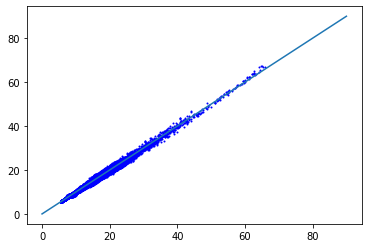

In [10]:
# 6분, 데이터셋 작을때는 gpu올리는 시간이 더 오래걸리기 때문에 그냥하는 것이 더 빠름
pred = bagging.bagging_prediction(x_train)
plt.plot(pred.reshape(-1), y_train.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

(49, 64, 64, 4)


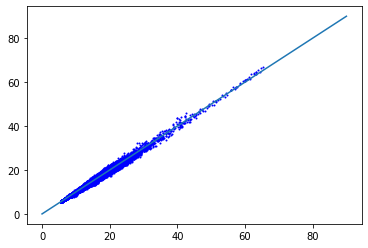

In [11]:
# 6분, 데이터셋 작을때는 gpu올리는 시간이 더 오래걸리기 때문에 그냥하는 것이 더 빠름
pred_test = bagging.bagging_prediction(x_test)
plt.plot(pred_test.reshape(-1), pm2_5.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

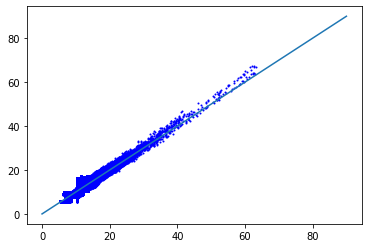

In [12]:
#weak net만 예측
pred_train_weaknet = weak_net(x_train).numpy()
plt.plot(pred_train_weaknet.reshape(-1), y_train.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

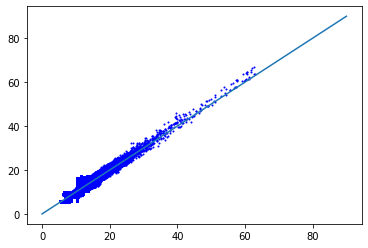

In [13]:
#weak net만 예측
pred_test_weaknet = weak_net(x_test).numpy()
plt.plot(pred_test_weaknet.reshape(-1), pm2_5.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: title={'center': 'pred_weak_net'}>

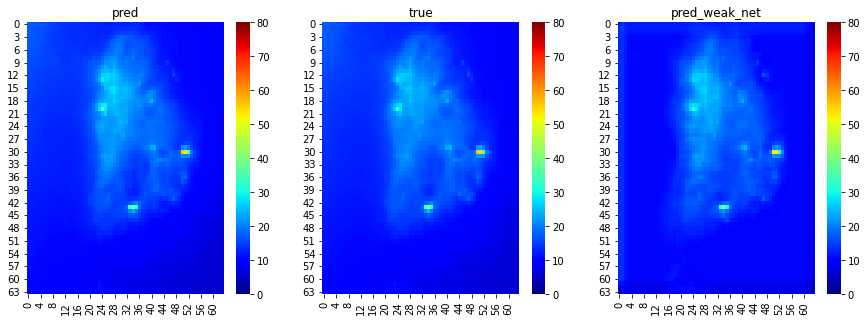

In [14]:
i = 0
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

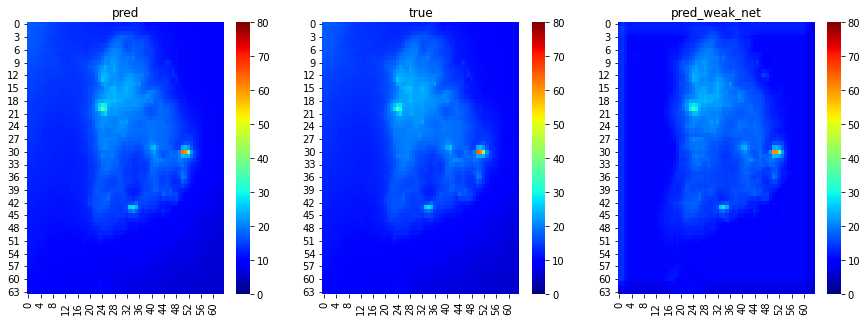

In [15]:
i = 1
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

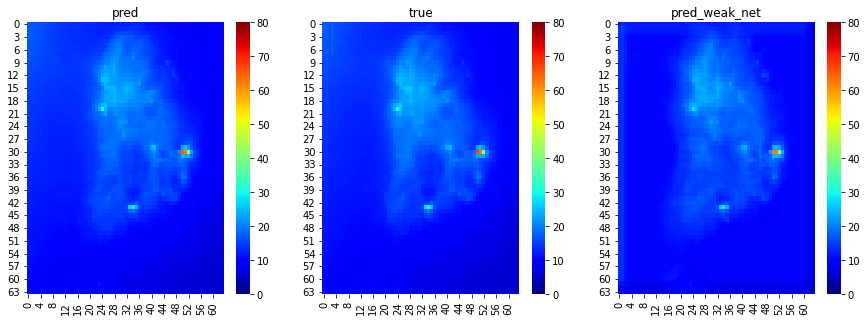

In [16]:
i = 2
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

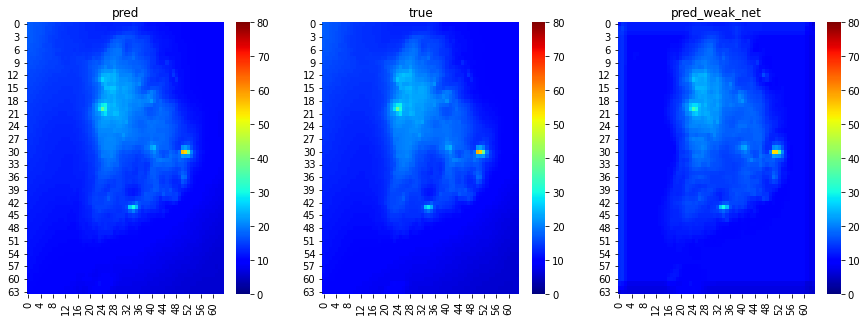

In [17]:
i = 3
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'pred_weak_net'}>

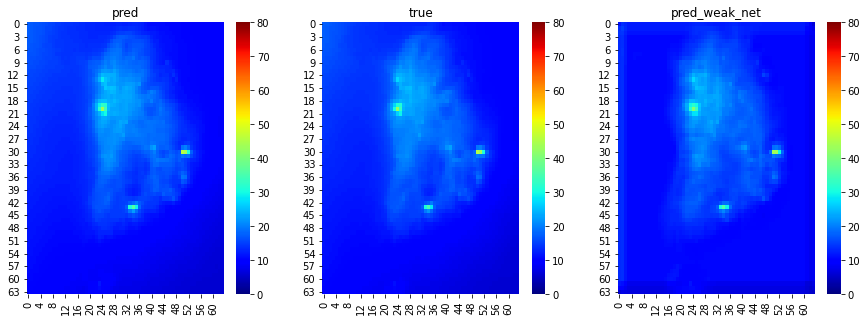

In [18]:
i = 4
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred_test[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('pred_weak_net')
sns.heatmap(pred_test_weaknet[i][:,:,0][::-1], cmap = 'jet',ax = ax1_3,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'final'}>

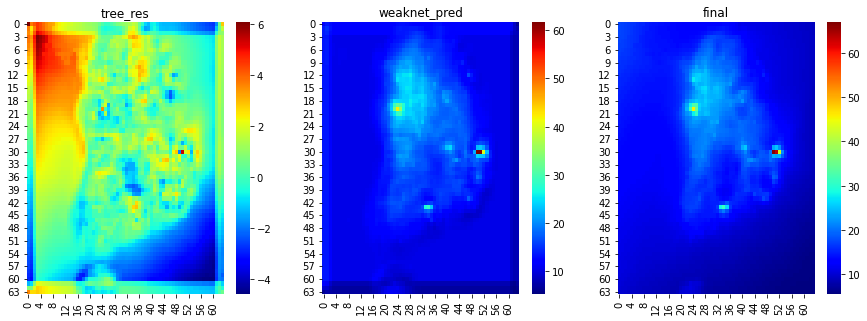

In [19]:
# bagging.tree_bootstrap[0].y_val[0]
i = 4
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('tree_res')
sns.heatmap(bagging.tree_bootstrap[0].y_val[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('weaknet_pred')
sns.heatmap(bagging.tree_bootstrap[0].res_y_val[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('final')
sns.heatmap(bagging.tree_bootstrap[0].y_val[i][:,:,0][::-1] + bagging.tree_bootstrap[0].res_y_val[4][:,:,0][::-1], cmap = 'jet',ax = ax1_3)


<AxesSubplot: title={'center': 'final'}>

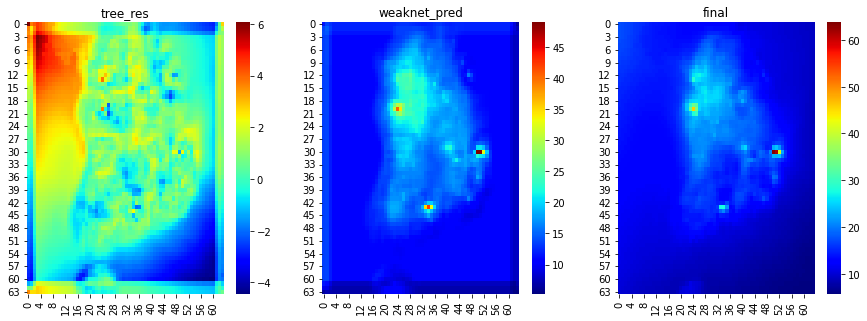

In [20]:
# bagging.tree_bootstrap[0].y_val[0]
i = 25
fig = plt.figure(figsize = (15,5))
        
ax1_1 = fig.add_subplot(1,3,1)
ax1_1.title.set_text('tree_res')
sns.heatmap(bagging.tree_bootstrap[0].y_val[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1)

ax1_2 = fig.add_subplot(1,3,2)
ax1_2.title.set_text('weaknet_pred')
sns.heatmap(bagging.tree_bootstrap[0].res_y_val[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2)

ax1_3 = fig.add_subplot(1,3,3)
ax1_3.title.set_text('final')
sns.heatmap(bagging.tree_bootstrap[0].y_val[i][:,:,0][::-1] + bagging.tree_bootstrap[0].res_y_val[4][:,:,0][::-1], cmap = 'jet',ax = ax1_3)


* TreeSHAP 추정
- 리프의 예측값이 일반 트리처럼 항상 고정되어있지는 않으므로 예측값 - 기여도합의 차이가 발생할 수 있음(Local accuracy의 bias, shapley value의 Efficiency)
(수정) 첫 피팅할때 pre model의 예측값으로 고정해서 해당 리프에서는 같은 값만 출력하도록 모델 수정하면됨


- 그러나 개별 노드에서 좌우를 이미지 유사도기준으로 나누므로 한 노드안에서 변동이 크지는 않을 것
- 사용하지 않는 픽셀은 0으로 두고 계산하므로 missingness는 괜찮을듯
- Consistency(Strong monotonicity) - 한 모델 f1에서 i가 빠진 여집합 보다 i포함값의 기여도가 f2에서보다 모든 s에서 크다면 f1에서 i 기여도 >= f2에서 i 기여도


* shap 계산 dynamic programming (indepedent tree 알고리즘)
- https://hughchen.github.io/its_blog/index.html#background_distribution 참고

In [10]:
import math

s_count = 0 # foreground 샘플에서만 만난 피처, pos 구할때는 1 빼준다
n_count = 2  # 지나면서 만난 전체 피처

def weight(sc,nc):
    pw = 0
    nw = 0
    if sc == 0:
        if nc != 0:
            nw = -1*(math.factorial(sc) * math.factorial(nc - sc - 1))/math.factorial(nc)
        return pw,nw
    if sc !=0:
        pw = (math.factorial(sc-1) * math.factorial(nc - (sc -1) - 1))/math.factorial(nc)
    if sc != nc:
        nw = -1*(math.factorial(sc) * math.factorial(nc - sc - 1))/math.factorial(nc)

    return pw, nw

weight(s_count,n_count)


def treeshap_dynamic(x_foreground, x_background, tree):

    def recurse(node_tree, n_c, s_c, foreground_check, background_check):
        

        if node_tree.is_terminal:
            pw, nw = weight(s_c,n_c)
            val_sum = (node_tree.y_val + node_tree.res_y_val).mean()    #여기를 만약에 sum으로하면 리프가 갖는 데이터셋 개수에 따라서 값차이가 생기므로 평균으로 처리해야함
            
            return val_sum * pw, val_sum * nw
        
        

        kernel_xf_val = x_foreground[node_tree.best_feature[0]:node_tree.best_feature[0]+node_tree.kernel_size[0],node_tree.best_feature[1]:node_tree.best_feature[1]+node_tree.kernel_size[1],node_tree.best_feature[2]].mean()
        kernel_xb_val = x_background[node_tree.best_feature[0]:node_tree.best_feature[0]+node_tree.kernel_size[0],node_tree.best_feature[1]:node_tree.best_feature[1]+node_tree.kernel_size[1],node_tree.best_feature[2]].mean()

        xf_child = node_tree.l_tree if kernel_xf_val < node_tree.best_feature_value else node_tree.r_tree
        xb_child = node_tree.l_tree if kernel_xb_val < node_tree.best_feature_value else node_tree.r_tree
            
        if foreground_check[str(node_tree.best_feature)] > 0:
            return recurse(xf_child,n_c,s_c, foreground_check, background_check)
        
        if background_check[str(node_tree.best_feature)] > 0:
            return recurse(xb_child,n_c,s_c, foreground_check, background_check)

        if xf_child == xb_child:
            return recurse(xb_child,n_c,s_c, foreground_check, background_check)

        if xf_child != xb_child:
            # foreground search
            foreground_check[str(node_tree.best_feature)] += 1
            posf, negf = recurse(xf_child,n_c + 1,s_c + 1, foreground_check, background_check)
            foreground_check[str(node_tree.best_feature)] -= 1


            # background search
            background_check[str(node_tree.best_feature)] += 1
            posb, negb = recurse(xb_child,n_c + 1,s_c, foreground_check, background_check)
            background_check[str(node_tree.best_feature)] -= 1

            # add phi
            phi_dic[str(node_tree.best_feature)] += (posf + negb)
            
            return posf + posb, negf + negb
    
    recurse(tree, 0, 0, feature_dic_forecheck, feature_dic_backcheck)




In [20]:
import matplotlib
# colors = ["#F80206", "#F53639", "#F77576", "#F6A1A3","#000000","#B7AEF8","#897AF6","#5843F9","#2003F9"]

colors_zero = ["#FFFFFF"]
colors_left = ["#140718","#120A2A","#0B0B3B","#0B0B61","#08088A","#0404B4","#0101DF","#0000FF","#2E64FE","#58ACFA","#81DAF5","#A9E2F3","#CEECF5","#E0F2F7","#EFF8FB",]
colors_right = ["#FF0000","#FF4000","#FF8000","#FFFF00","#BFFF00","#80FF00","#9AFE2E","#ACFA58","#BEF781","#D0F5A9","#D8F6CE","#E6F8E0","#EFFBEF",]
colors_right.reverse()

colors = colors_left + colors_zero + colors_right


# colors.reverse()
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("name", colors)
norm = plt.Normalize(-0.05, 0.05)

(1, 64, 64, 4)


<AxesSubplot: title={'center': 'true'}>

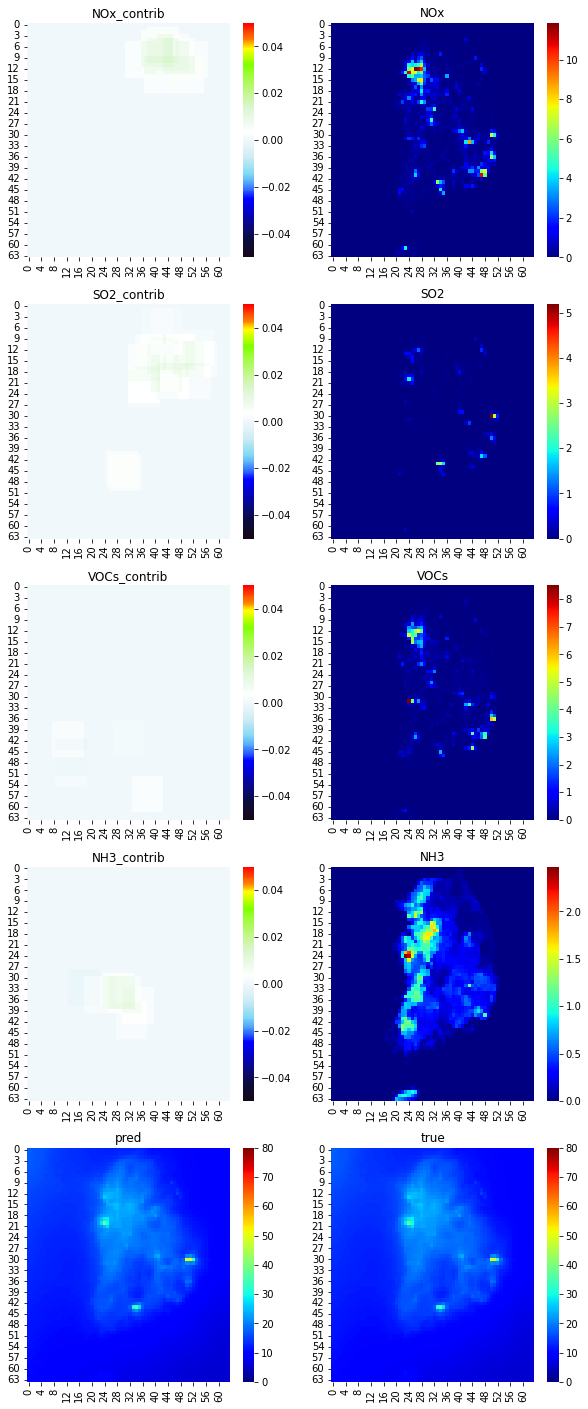

In [21]:
x_ind = 0
contrib_map = np.zeros(x_train[x_ind].shape)

for j in range(n_weak_tree):
    target_tree = bagging.tree_bootstrap[j]
    structure, feature_list = target_tree.get_tree_structure()
# predict(self ,x_arr)
    # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
    phi_dic = {}
    for i in range(len(feature_list)):
        phi_dic[str(feature_list[i])] = 0

    
    for i in range(len(x_train)):
        # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
        feature_dic_forecheck = {}
        feature_dic_backcheck = {}
        for i in range(len(feature_list)):
            feature_dic_forecheck[str(feature_list[i])] = 0
            feature_dic_backcheck[str(feature_list[i])] = 0
        
        
        treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
    
    # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
    for i in range(len(feature_list)):
        phi_dic[str(feature_list[i])] /= len(x_train)
    
    
    for feat in feature_list:
        contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
    # print(phi_dic,)
contrib_map /= n_weak_tree

# bagging.tree_bootstrap[0].y_val[0]
fig = plt.figure(figsize = (10,25))
        
ax1_1 = fig.add_subplot(5,2,1)
ax1_1.title.set_text('NOx_contrib')
sns.heatmap(contrib_map[:,:,0][::-1], cmap = cmap,norm=norm,ax = ax1_1)

ax1_2 = fig.add_subplot(5,2,2)
ax1_2.title.set_text('NOx')
sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2)

ax2_1 = fig.add_subplot(5,2,3)
ax2_1.title.set_text('SO2_contrib')
sns.heatmap(contrib_map[:,:,1][::-1], cmap = cmap,norm=norm,ax = ax2_1)

ax2_2 = fig.add_subplot(5,2,4)
ax2_2.title.set_text('SO2')
sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2)

ax3_1 = fig.add_subplot(5,2,5)
ax3_1.title.set_text('VOCs_contrib')
sns.heatmap(contrib_map[:,:,2][::-1], cmap = cmap,norm=norm,ax = ax3_1)

ax3_2 = fig.add_subplot(5,2,6)
ax3_2.title.set_text('VOCs')
sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2)

ax4_1 = fig.add_subplot(5,2,7)
ax4_1.title.set_text('NH3_contrib')
sns.heatmap(contrib_map[:,:,3][::-1], cmap = cmap,norm=norm,ax = ax4_1)

ax4_2 = fig.add_subplot(5,2,8)
ax4_2.title.set_text('NH3')
sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2)

ax5_1 = fig.add_subplot(5,2,9)
ax5_1.title.set_text('pred')
sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

ax5_2 = fig.add_subplot(5,2,10)
ax5_2.title.set_text('true')
sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

In [25]:
x_ind = 7
contrib_map = np.zeros(x_train[x_ind].shape)

for j in range(n_weak_tree):
    target_tree = bagging.tree_bootstrap[j]
    structure, feature_list = target_tree.get_tree_structure()
# predict(self ,x_arr)
    # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
    phi_dic = {}
    for i in range(len(feature_list)):
        phi_dic[str(feature_list[i])] = 0

    
    for i in range(len(x_train)):
        # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
        feature_dic_forecheck = {}
        feature_dic_backcheck = {}
        for i in range(len(feature_list)):
            feature_dic_forecheck[str(feature_list[i])] = 0
            feature_dic_backcheck[str(feature_list[i])] = 0
        
        
        treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
    
    # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
    for i in range(len(feature_list)):
        phi_dic[str(feature_list[i])] /= len(x_train)
    
    
    for feat in feature_list:
        contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
    # print(phi_dic,)
contrib_map /= n_weak_tree

# bagging.tree_bootstrap[0].y_val[0]
fig = plt.figure(figsize = (10,25))
        
ax1_1 = fig.add_subplot(5,2,1)
ax1_1.title.set_text('NOx_contrib') 
sns.heatmap(contrib_map[:,:,0][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm() if contrib_map.mean() !=0 else None,ax = ax1_1)

ax1_2 = fig.add_subplot(5,2,2)
ax1_2.title.set_text('NOx')
sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2)

ax2_1 = fig.add_subplot(5,2,3)
ax2_1.title.set_text('SO2_contrib')
sns.heatmap(contrib_map[:,:,1][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm() if contrib_map.mean() !=0 else None,ax = ax2_1)

ax2_2 = fig.add_subplot(5,2,4)
ax2_2.title.set_text('SO2')
sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2)

ax3_1 = fig.add_subplot(5,2,5)
ax3_1.title.set_text('VOCs_contrib')
sns.heatmap(contrib_map[:,:,2][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm() if contrib_map.mean() !=0 else None,ax = ax3_1)

ax3_2 = fig.add_subplot(5,2,6)
ax3_2.title.set_text('VOCs')
sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2)

ax4_1 = fig.add_subplot(5,2,7)
ax4_1.title.set_text('NH3_contrib')
sns.heatmap(contrib_map[:,:,3][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm() if contrib_map.mean() !=0 else None,ax = ax4_1)

ax4_2 = fig.add_subplot(5,2,8)
ax4_2.title.set_text('NH3')
sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2)

ax5_1 = fig.add_subplot(5,2,9)
ax5_1.title.set_text('pred')
sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

ax5_2 = fig.add_subplot(5,2,10)
ax5_2.title.set_text('true')
sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

# plt.savefig(f"plots/contrib3/{x_ind}_{k_size}_{k_n}_{n_weak_tree}_contrib.png")
# plt.close()

: 

: 

In [92]:

%%time
for x_ind in range(len(x_train)):
    if x_ind == x_ind: break

    contrib_map = np.zeros(x_train[x_ind].shape)

    for j in range(n_weak_tree):
        target_tree = bagging.tree_bootstrap[j]
        structure, feature_list = target_tree.get_tree_structure()
    # predict(self ,x_arr)
        # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
        phi_dic = {}
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] = 0

        
        for i in range(len(x_train)):
            # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
            feature_dic_forecheck = {}
            feature_dic_backcheck = {}
            for i in range(len(feature_list)):
                feature_dic_forecheck[str(feature_list[i])] = 0
                feature_dic_backcheck[str(feature_list[i])] = 0
            
            
            treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
        
        # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] /= len(x_train)
        
        
        for feat in feature_list:
            contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
        # print(phi_dic,)
    contrib_map /= n_weak_tree

    # bagging.tree_bootstrap[0].y_val[0]
    fig = plt.figure(figsize = (10,25))
            
    ax1_1 = fig.add_subplot(5,2,1)
    ax1_1.title.set_text('NOx_contrib') 
    sns.heatmap(contrib_map[:,:,0][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm(),ax = ax1_1)

    ax1_2 = fig.add_subplot(5,2,2)
    ax1_2.title.set_text('NOx')
    sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2)

    ax2_1 = fig.add_subplot(5,2,3)
    ax2_1.title.set_text('SO2_contrib')
    sns.heatmap(contrib_map[:,:,1][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm(),ax = ax2_1)

    ax2_2 = fig.add_subplot(5,2,4)
    ax2_2.title.set_text('SO2')
    sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2)

    ax3_1 = fig.add_subplot(5,2,5)
    ax3_1.title.set_text('VOCs_contrib')
    sns.heatmap(contrib_map[:,:,2][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm(),ax = ax3_1)

    ax3_2 = fig.add_subplot(5,2,6)
    ax3_2.title.set_text('VOCs')
    sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2)

    ax4_1 = fig.add_subplot(5,2,7)
    ax4_1.title.set_text('NH3_contrib')
    sns.heatmap(contrib_map[:,:,3][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm(),ax = ax4_1)

    ax4_2 = fig.add_subplot(5,2,8)
    ax4_2.title.set_text('NH3')
    sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2)

    ax5_1 = fig.add_subplot(5,2,9)
    ax5_1.title.set_text('pred')
    sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

    ax5_2 = fig.add_subplot(5,2,10)
    ax5_2.title.set_text('true')
    sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

    plt.savefig(f"plots/contrib3/{x_ind}_{k_size}_{k_n}_{n_weak_tree}_contrib.png")
    plt.close()

(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)


: 

: 

* 나머지 테스트

In [11]:
%%time

min_sam_leaf = 5
k_size = [10,10]
k_n = 30
n_weak_tree = 10


bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= min_sam_leaf,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= k_size,
    kernel_n= k_n,

    input_shape= x_train.shape,

    n_tree= n_weak_tree,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()


for x_ind in range(len(x_train)):
    contrib_map = np.zeros(x_train[x_ind].shape)

    for j in range(n_weak_tree):
        target_tree = bagging.tree_bootstrap[j]
        structure, feature_list = target_tree.get_tree_structure()
    # predict(self ,x_arr)
        # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
        phi_dic = {}
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] = 0

        
        for i in range(len(x_train)):
            # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
            feature_dic_forecheck = {}
            feature_dic_backcheck = {}
            for i in range(len(feature_list)):
                feature_dic_forecheck[str(feature_list[i])] = 0
                feature_dic_backcheck[str(feature_list[i])] = 0
            
            
            treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
        
        # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] /= len(x_train)
        
        
        for feat in feature_list:
            contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
        # print(phi_dic,)
    contrib_map /= n_weak_tree

    # bagging.tree_bootstrap[0].y_val[0]
    fig = plt.figure(figsize = (10,25))
            
    ax1_1 = fig.add_subplot(5,2,1)
    ax1_1.title.set_text('NOx_contrib') 
    sns.heatmap(contrib_map[:,:,0][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm() if contrib_map.mean() !=0 else None,ax = ax1_1)

    ax1_2 = fig.add_subplot(5,2,2)
    ax1_2.title.set_text('NOx')
    sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2)

    ax2_1 = fig.add_subplot(5,2,3)
    ax2_1.title.set_text('SO2_contrib')
    sns.heatmap(contrib_map[:,:,1][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm() if contrib_map.mean() !=0 else None,ax = ax2_1)

    ax2_2 = fig.add_subplot(5,2,4)
    ax2_2.title.set_text('SO2')
    sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2)

    ax3_1 = fig.add_subplot(5,2,5)
    ax3_1.title.set_text('VOCs_contrib')
    sns.heatmap(contrib_map[:,:,2][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm() if contrib_map.mean() !=0 else None,ax = ax3_1)

    ax3_2 = fig.add_subplot(5,2,6)
    ax3_2.title.set_text('VOCs')
    sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2)

    ax4_1 = fig.add_subplot(5,2,7)
    ax4_1.title.set_text('NH3_contrib')
    sns.heatmap(contrib_map[:,:,3][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm() if contrib_map.mean() !=0 else None,ax = ax4_1)

    ax4_2 = fig.add_subplot(5,2,8)
    ax4_2.title.set_text('NH3')
    sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2)

    ax5_1 = fig.add_subplot(5,2,9)
    ax5_1.title.set_text('pred')
    sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

    ax5_2 = fig.add_subplot(5,2,10)
    ax5_2.title.set_text('true')
    sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

    plt.savefig(f"plots/contrib3/{x_ind}_{k_size}_{k_n}_{n_weak_tree}_contrib.png")
    plt.close()





0
1
2
3
4
5
6
7
8
9


: 

: 

In [9]:
%%time

min_sam_leaf = 5
k_size = [20,20]
k_n = 30
n_weak_tree = 200


bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= min_sam_leaf,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= k_size,
    kernel_n= k_n,

    input_shape= x_train.shape,

    n_tree= n_weak_tree,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()


for x_ind in range(len(x_train)):
    contrib_map = np.zeros(x_train[x_ind].shape)

    for j in range(n_weak_tree):
        target_tree = bagging.tree_bootstrap[j]
        structure, feature_list = target_tree.get_tree_structure()
    # predict(self ,x_arr)
        # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
        phi_dic = {}
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] = 0

        
        for i in range(len(x_train)):
            # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
            feature_dic_forecheck = {}
            feature_dic_backcheck = {}
            for i in range(len(feature_list)):
                feature_dic_forecheck[str(feature_list[i])] = 0
                feature_dic_backcheck[str(feature_list[i])] = 0
            
            
            treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
        
        # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] /= len(x_train)
        
        
        for feat in feature_list:
            contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
        # print(phi_dic,)
    contrib_map /= n_weak_tree

    # bagging.tree_bootstrap[0].y_val[0]
    fig = plt.figure(figsize = (10,25))
            
    ax1_1 = fig.add_subplot(5,2,1)
    ax1_1.title.set_text('NOx_contrib') 
    sns.heatmap(contrib_map[:,:,0][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm(),ax = ax1_1)

    ax1_2 = fig.add_subplot(5,2,2)
    ax1_2.title.set_text('NOx')
    sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2)

    ax2_1 = fig.add_subplot(5,2,3)
    ax2_1.title.set_text('SO2_contrib')
    sns.heatmap(contrib_map[:,:,1][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm(),ax = ax2_1)

    ax2_2 = fig.add_subplot(5,2,4)
    ax2_2.title.set_text('SO2')
    sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2)

    ax3_1 = fig.add_subplot(5,2,5)
    ax3_1.title.set_text('VOCs_contrib')
    sns.heatmap(contrib_map[:,:,2][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm(),ax = ax3_1)

    ax3_2 = fig.add_subplot(5,2,6)
    ax3_2.title.set_text('VOCs')
    sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2)

    ax4_1 = fig.add_subplot(5,2,7)
    ax4_1.title.set_text('NH3_contrib')
    sns.heatmap(contrib_map[:,:,3][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm(),ax = ax4_1)

    ax4_2 = fig.add_subplot(5,2,8)
    ax4_2.title.set_text('NH3')
    sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2)

    ax5_1 = fig.add_subplot(5,2,9)
    ax5_1.title.set_text('pred')
    sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

    ax5_2 = fig.add_subplot(5,2,10)
    ax5_2.title.set_text('true')
    sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

    plt.savefig(f"plots/contrib3/{x_ind}_{k_size}_{k_n}_{n_weak_tree}_contrib.png")
    plt.close()





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)


: 

: 

In [ ]:
%%time

min_sam_leaf = 5
k_size = [30,30]
k_n = 30
n_weak_tree = 200


bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= min_sam_leaf,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= k_size,
    kernel_n= k_n,

    input_shape= x_train.shape,

    n_tree= n_weak_tree,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()


for x_ind in range(len(x_train)):
    contrib_map = np.zeros(x_train[x_ind].shape)

    for j in range(n_weak_tree):
        target_tree = bagging.tree_bootstrap[j]
        structure, feature_list = target_tree.get_tree_structure()
    # predict(self ,x_arr)
        # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
        phi_dic = {}
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] = 0

        
        for i in range(len(x_train)):
            # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
            feature_dic_forecheck = {}
            feature_dic_backcheck = {}
            for i in range(len(feature_list)):
                feature_dic_forecheck[str(feature_list[i])] = 0
                feature_dic_backcheck[str(feature_list[i])] = 0
            
            
            treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
        
        # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] /= len(x_train)
        
        
        for feat in feature_list:
            contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
        # print(phi_dic,)
    contrib_map /= n_weak_tree

    # bagging.tree_bootstrap[0].y_val[0]
    fig = plt.figure(figsize = (10,25))
            
    ax1_1 = fig.add_subplot(5,2,1)
    ax1_1.title.set_text('NOx_contrib') 
    sns.heatmap(contrib_map[:,:,0][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm(),ax = ax1_1)

    ax1_2 = fig.add_subplot(5,2,2)
    ax1_2.title.set_text('NOx')
    sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2)

    ax2_1 = fig.add_subplot(5,2,3)
    ax2_1.title.set_text('SO2_contrib')
    sns.heatmap(contrib_map[:,:,1][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm(),ax = ax2_1)

    ax2_2 = fig.add_subplot(5,2,4)
    ax2_2.title.set_text('SO2')
    sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2)

    ax3_1 = fig.add_subplot(5,2,5)
    ax3_1.title.set_text('VOCs_contrib')
    sns.heatmap(contrib_map[:,:,2][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm(),ax = ax3_1)

    ax3_2 = fig.add_subplot(5,2,6)
    ax3_2.title.set_text('VOCs')
    sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2)

    ax4_1 = fig.add_subplot(5,2,7)
    ax4_1.title.set_text('NH3_contrib')
    sns.heatmap(contrib_map[:,:,3][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm(),ax = ax4_1)

    ax4_2 = fig.add_subplot(5,2,8)
    ax4_2.title.set_text('NH3')
    sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2)

    ax5_1 = fig.add_subplot(5,2,9)
    ax5_1.title.set_text('pred')
    sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

    ax5_2 = fig.add_subplot(5,2,10)
    ax5_2.title.set_text('true')
    sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

    plt.savefig(f"plots/contrib3/{x_ind}_{k_size}_{k_n}_{n_weak_tree}_contrib.png")
    plt.close()





In [8]:
%%time

min_sam_leaf = 5
k_size = [20,20]
k_n = 30
n_weak_tree = 100


bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= min_sam_leaf,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= k_size,
    kernel_n= k_n,

    input_shape= x_train.shape,

    n_tree= n_weak_tree,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()


for x_ind in range(len(x_train)):
    contrib_map = np.zeros(x_train[x_ind].shape)

    for j in range(n_weak_tree):
        target_tree = bagging.tree_bootstrap[j]
        structure, feature_list = target_tree.get_tree_structure()
    # predict(self ,x_arr)
        # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
        phi_dic = {}
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] = 0

        
        for i in range(len(x_train)):
            # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
            feature_dic_forecheck = {}
            feature_dic_backcheck = {}
            for i in range(len(feature_list)):
                feature_dic_forecheck[str(feature_list[i])] = 0
                feature_dic_backcheck[str(feature_list[i])] = 0
            
            
            treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
        
        # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] /= len(x_train)
        
        
        for feat in feature_list:
            contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
        # print(phi_dic,)
    contrib_map /= n_weak_tree

    # bagging.tree_bootstrap[0].y_val[0]
    fig = plt.figure(figsize = (10,25))
            
    ax1_1 = fig.add_subplot(5,2,1)
    ax1_1.title.set_text('NOx_contrib') 
    sns.heatmap(contrib_map[:,:,0][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm(),ax = ax1_1)

    ax1_2 = fig.add_subplot(5,2,2)
    ax1_2.title.set_text('NOx')
    sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2)

    ax2_1 = fig.add_subplot(5,2,3)
    ax2_1.title.set_text('SO2_contrib')
    sns.heatmap(contrib_map[:,:,1][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm(),ax = ax2_1)

    ax2_2 = fig.add_subplot(5,2,4)
    ax2_2.title.set_text('SO2')
    sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2)

    ax3_1 = fig.add_subplot(5,2,5)
    ax3_1.title.set_text('VOCs_contrib')
    sns.heatmap(contrib_map[:,:,2][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm(),ax = ax3_1)

    ax3_2 = fig.add_subplot(5,2,6)
    ax3_2.title.set_text('VOCs')
    sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2)

    ax4_1 = fig.add_subplot(5,2,7)
    ax4_1.title.set_text('NH3_contrib')
    sns.heatmap(contrib_map[:,:,3][::-1], cmap = 'jet',norm = matplotlib.colors.CenteredNorm(),ax = ax4_1)

    ax4_2 = fig.add_subplot(5,2,8)
    ax4_2.title.set_text('NH3')
    sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2)

    ax5_1 = fig.add_subplot(5,2,9)
    ax5_1.title.set_text('pred')
    sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

    ax5_2 = fig.add_subplot(5,2,10)
    ax5_2.title.set_text('true')
    sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

    plt.savefig(f"plots/contrib3/{x_ind}_{k_size}_{k_n}_{n_weak_tree}_contrib.png")
    plt.close()





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


NameError: name 'treeshap_dynamic' is not defined

In [395]:
%%time

min_sam_leaf = 5
k_size = [3,3]
k_n = 40
n_weak_tree = 30


bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= min_sam_leaf,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= k_size,
    kernel_n= k_n,

    input_shape= x_train.shape,

    n_tree= n_weak_tree,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()


for x_ind in range(len(x_train)):

    contrib_map = np.zeros(x_train[x_ind].shape)

    for j in range(n_weak_tree):
        target_tree = bagging.tree_bootstrap[j]
        structure, feature_list = target_tree.get_tree_structure()
    # predict(self ,x_arr)
        # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
        phi_dic = {}
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] = 0

        
        for i in range(len(x_train)):
            # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
            feature_dic_forecheck = {}
            feature_dic_backcheck = {}
            for i in range(len(feature_list)):
                feature_dic_forecheck[str(feature_list[i])] = 0
                feature_dic_backcheck[str(feature_list[i])] = 0
            
            
            treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
        
        # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] /= len(x_train)
        
        
        for feat in feature_list:
            contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
        # print(phi_dic,)
    contrib_map /= n_weak_tree

    # bagging.tree_bootstrap[0].y_val[0]
    fig = plt.figure(figsize = (10,25))
            
    ax1_1 = fig.add_subplot(5,2,1)
    ax1_1.title.set_text('NOx_contrib')
    sns.heatmap(contrib_map[:,:,0][::-1], cmap = 'jet',ax = ax1_1)

    ax1_2 = fig.add_subplot(5,2,2)
    ax1_2.title.set_text('NOx')
    sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2)

    ax2_1 = fig.add_subplot(5,2,3)
    ax2_1.title.set_text('SO2_contrib')
    sns.heatmap(contrib_map[:,:,1][::-1], cmap = 'jet',ax = ax2_1)

    ax2_2 = fig.add_subplot(5,2,4)
    ax2_2.title.set_text('SO2')
    sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2)

    ax3_1 = fig.add_subplot(5,2,5)
    ax3_1.title.set_text('VOCs_contrib')
    sns.heatmap(contrib_map[:,:,2][::-1], cmap = 'jet',ax = ax3_1)

    ax3_2 = fig.add_subplot(5,2,6)
    ax3_2.title.set_text('VOCs')
    sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2)

    ax4_1 = fig.add_subplot(5,2,7)
    ax4_1.title.set_text('NH3_contrib')
    sns.heatmap(contrib_map[:,:,3][::-1], cmap = 'jet',ax = ax4_1)

    ax4_2 = fig.add_subplot(5,2,8)
    ax4_2.title.set_text('NH3')
    sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2)

    ax5_1 = fig.add_subplot(5,2,9)
    ax5_1.title.set_text('pred')
    sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

    ax5_2 = fig.add_subplot(5,2,10)
    ax5_2.title.set_text('true')
    sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

    plt.savefig(f"plots/contrib/{x_ind}_{k_size}_{k_n}_{n_weak_tree}_contrib.png")
    plt.close()





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 6

In [396]:
%%time

min_sam_leaf = 5
k_size = [3,3]
k_n = 50
n_weak_tree = 30


bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= min_sam_leaf,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= k_size,
    kernel_n= k_n,

    input_shape= x_train.shape,

    n_tree= n_weak_tree,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()


for x_ind in range(len(x_train)):

    contrib_map = np.zeros(x_train[x_ind].shape)

    for j in range(n_weak_tree):
        target_tree = bagging.tree_bootstrap[j]
        structure, feature_list = target_tree.get_tree_structure()
    # predict(self ,x_arr)
        # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
        phi_dic = {}
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] = 0

        
        for i in range(len(x_train)):
            # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
            feature_dic_forecheck = {}
            feature_dic_backcheck = {}
            for i in range(len(feature_list)):
                feature_dic_forecheck[str(feature_list[i])] = 0
                feature_dic_backcheck[str(feature_list[i])] = 0
            
            
            treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
        
        # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] /= len(x_train)
        
        
        for feat in feature_list:
            contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
        # print(phi_dic,)
    contrib_map /= n_weak_tree

    # bagging.tree_bootstrap[0].y_val[0]
    fig = plt.figure(figsize = (10,25))
            
    ax1_1 = fig.add_subplot(5,2,1)
    ax1_1.title.set_text('NOx_contrib')
    sns.heatmap(contrib_map[:,:,0][::-1], cmap = 'jet',ax = ax1_1)

    ax1_2 = fig.add_subplot(5,2,2)
    ax1_2.title.set_text('NOx')
    sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2)

    ax2_1 = fig.add_subplot(5,2,3)
    ax2_1.title.set_text('SO2_contrib')
    sns.heatmap(contrib_map[:,:,1][::-1], cmap = 'jet',ax = ax2_1)

    ax2_2 = fig.add_subplot(5,2,4)
    ax2_2.title.set_text('SO2')
    sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2)

    ax3_1 = fig.add_subplot(5,2,5)
    ax3_1.title.set_text('VOCs_contrib')
    sns.heatmap(contrib_map[:,:,2][::-1], cmap = 'jet',ax = ax3_1)

    ax3_2 = fig.add_subplot(5,2,6)
    ax3_2.title.set_text('VOCs')
    sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2)

    ax4_1 = fig.add_subplot(5,2,7)
    ax4_1.title.set_text('NH3_contrib')
    sns.heatmap(contrib_map[:,:,3][::-1], cmap = 'jet',ax = ax4_1)

    ax4_2 = fig.add_subplot(5,2,8)
    ax4_2.title.set_text('NH3')
    sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2)

    ax5_1 = fig.add_subplot(5,2,9)
    ax5_1.title.set_text('pred')
    sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

    ax5_2 = fig.add_subplot(5,2,10)
    ax5_2.title.set_text('true')
    sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

    plt.savefig(f"plots/contrib/{x_ind}_{k_size}_{k_n}_{n_weak_tree}_contrib.png")
    plt.close()





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 6

In [397]:
%%time

min_sam_leaf = 5
k_size = [3,3]
k_n = 30
n_weak_tree = 50


bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= min_sam_leaf,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= k_size,
    kernel_n= k_n,

    input_shape= x_train.shape,

    n_tree= n_weak_tree,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()


for x_ind in range(len(x_train)):

    contrib_map = np.zeros(x_train[x_ind].shape)

    for j in range(n_weak_tree):
        target_tree = bagging.tree_bootstrap[j]
        structure, feature_list = target_tree.get_tree_structure()
    # predict(self ,x_arr)
        # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
        phi_dic = {}
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] = 0

        
        for i in range(len(x_train)):
            # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
            feature_dic_forecheck = {}
            feature_dic_backcheck = {}
            for i in range(len(feature_list)):
                feature_dic_forecheck[str(feature_list[i])] = 0
                feature_dic_backcheck[str(feature_list[i])] = 0
            
            
            treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
        
        # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] /= len(x_train)
        
        
        for feat in feature_list:
            contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
        # print(phi_dic,)
    contrib_map /= n_weak_tree

    # bagging.tree_bootstrap[0].y_val[0]
    fig = plt.figure(figsize = (10,25))
            
    ax1_1 = fig.add_subplot(5,2,1)
    ax1_1.title.set_text('NOx_contrib')
    sns.heatmap(contrib_map[:,:,0][::-1], cmap = 'jet',ax = ax1_1)

    ax1_2 = fig.add_subplot(5,2,2)
    ax1_2.title.set_text('NOx')
    sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2)

    ax2_1 = fig.add_subplot(5,2,3)
    ax2_1.title.set_text('SO2_contrib')
    sns.heatmap(contrib_map[:,:,1][::-1], cmap = 'jet',ax = ax2_1)

    ax2_2 = fig.add_subplot(5,2,4)
    ax2_2.title.set_text('SO2')
    sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2)

    ax3_1 = fig.add_subplot(5,2,5)
    ax3_1.title.set_text('VOCs_contrib')
    sns.heatmap(contrib_map[:,:,2][::-1], cmap = 'jet',ax = ax3_1)

    ax3_2 = fig.add_subplot(5,2,6)
    ax3_2.title.set_text('VOCs')
    sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2)

    ax4_1 = fig.add_subplot(5,2,7)
    ax4_1.title.set_text('NH3_contrib')
    sns.heatmap(contrib_map[:,:,3][::-1], cmap = 'jet',ax = ax4_1)

    ax4_2 = fig.add_subplot(5,2,8)
    ax4_2.title.set_text('NH3')
    sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2)

    ax5_1 = fig.add_subplot(5,2,9)
    ax5_1.title.set_text('pred')
    sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

    ax5_2 = fig.add_subplot(5,2,10)
    ax5_2.title.set_text('true')
    sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

    plt.savefig(f"plots/contrib/{x_ind}_{k_size}_{k_n}_{n_weak_tree}_contrib.png")
    plt.close()





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 6

In [398]:
%%time

min_sam_leaf = 5
k_size = [3,3]
k_n = 30
n_weak_tree = 100


bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= min_sam_leaf,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= k_size,
    kernel_n= k_n,

    input_shape= x_train.shape,

    n_tree= n_weak_tree,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()


for x_ind in range(len(x_train)):

    contrib_map = np.zeros(x_train[x_ind].shape)

    for j in range(n_weak_tree):
        target_tree = bagging.tree_bootstrap[j]
        structure, feature_list = target_tree.get_tree_structure()
    # predict(self ,x_arr)
        # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
        phi_dic = {}
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] = 0

        
        for i in range(len(x_train)):
            # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
            feature_dic_forecheck = {}
            feature_dic_backcheck = {}
            for i in range(len(feature_list)):
                feature_dic_forecheck[str(feature_list[i])] = 0
                feature_dic_backcheck[str(feature_list[i])] = 0
            
            
            treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
        
        # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] /= len(x_train)
        
        
        for feat in feature_list:
            contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
        # print(phi_dic,)
    contrib_map /= n_weak_tree

    # bagging.tree_bootstrap[0].y_val[0]
    fig = plt.figure(figsize = (10,25))
            
    ax1_1 = fig.add_subplot(5,2,1)
    ax1_1.title.set_text('NOx_contrib')
    sns.heatmap(contrib_map[:,:,0][::-1], cmap = 'jet',ax = ax1_1)

    ax1_2 = fig.add_subplot(5,2,2)
    ax1_2.title.set_text('NOx')
    sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2)

    ax2_1 = fig.add_subplot(5,2,3)
    ax2_1.title.set_text('SO2_contrib')
    sns.heatmap(contrib_map[:,:,1][::-1], cmap = 'jet',ax = ax2_1)

    ax2_2 = fig.add_subplot(5,2,4)
    ax2_2.title.set_text('SO2')
    sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2)

    ax3_1 = fig.add_subplot(5,2,5)
    ax3_1.title.set_text('VOCs_contrib')
    sns.heatmap(contrib_map[:,:,2][::-1], cmap = 'jet',ax = ax3_1)

    ax3_2 = fig.add_subplot(5,2,6)
    ax3_2.title.set_text('VOCs')
    sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2)

    ax4_1 = fig.add_subplot(5,2,7)
    ax4_1.title.set_text('NH3_contrib')
    sns.heatmap(contrib_map[:,:,3][::-1], cmap = 'jet',ax = ax4_1)

    ax4_2 = fig.add_subplot(5,2,8)
    ax4_2.title.set_text('NH3')
    sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2)

    ax5_1 = fig.add_subplot(5,2,9)
    ax5_1.title.set_text('pred')
    sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

    ax5_2 = fig.add_subplot(5,2,10)
    ax5_2.title.set_text('true')
    sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

    plt.savefig(f"plots/contrib/{x_ind}_{k_size}_{k_n}_{n_weak_tree}_contrib.png")
    plt.close()





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 6

In [399]:
%%time

min_sam_leaf = 5
k_size = [3,3]
k_n = 30
n_weak_tree = 200


bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= min_sam_leaf,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= k_size,
    kernel_n= k_n,

    input_shape= x_train.shape,

    n_tree= n_weak_tree,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()


for x_ind in range(len(x_train)):

    contrib_map = np.zeros(x_train[x_ind].shape)

    for j in range(n_weak_tree):
        target_tree = bagging.tree_bootstrap[j]
        structure, feature_list = target_tree.get_tree_structure()
    # predict(self ,x_arr)
        # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
        phi_dic = {}
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] = 0

        
        for i in range(len(x_train)):
            # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
            feature_dic_forecheck = {}
            feature_dic_backcheck = {}
            for i in range(len(feature_list)):
                feature_dic_forecheck[str(feature_list[i])] = 0
                feature_dic_backcheck[str(feature_list[i])] = 0
            
            
            treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
        
        # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] /= len(x_train)
        
        
        for feat in feature_list:
            contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
        # print(phi_dic,)
    contrib_map /= n_weak_tree

    # bagging.tree_bootstrap[0].y_val[0]
    fig = plt.figure(figsize = (10,25))
            
    ax1_1 = fig.add_subplot(5,2,1)
    ax1_1.title.set_text('NOx_contrib')
    sns.heatmap(contrib_map[:,:,0][::-1], cmap = 'jet',ax = ax1_1)

    ax1_2 = fig.add_subplot(5,2,2)
    ax1_2.title.set_text('NOx')
    sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2)

    ax2_1 = fig.add_subplot(5,2,3)
    ax2_1.title.set_text('SO2_contrib')
    sns.heatmap(contrib_map[:,:,1][::-1], cmap = 'jet',ax = ax2_1)

    ax2_2 = fig.add_subplot(5,2,4)
    ax2_2.title.set_text('SO2')
    sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2)

    ax3_1 = fig.add_subplot(5,2,5)
    ax3_1.title.set_text('VOCs_contrib')
    sns.heatmap(contrib_map[:,:,2][::-1], cmap = 'jet',ax = ax3_1)

    ax3_2 = fig.add_subplot(5,2,6)
    ax3_2.title.set_text('VOCs')
    sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2)

    ax4_1 = fig.add_subplot(5,2,7)
    ax4_1.title.set_text('NH3_contrib')
    sns.heatmap(contrib_map[:,:,3][::-1], cmap = 'jet',ax = ax4_1)

    ax4_2 = fig.add_subplot(5,2,8)
    ax4_2.title.set_text('NH3')
    sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2)

    ax5_1 = fig.add_subplot(5,2,9)
    ax5_1.title.set_text('pred')
    sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

    ax5_2 = fig.add_subplot(5,2,10)
    ax5_2.title.set_text('true')
    sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

    plt.savefig(f"plots/contrib/{x_ind}_{k_size}_{k_n}_{n_weak_tree}_contrib.png")
    plt.close()





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64, 4)
(1, 64, 64

In [400]:
%%time

min_sam_leaf = 5
k_size = [3,3]
k_n = 100
n_weak_tree = 300


bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= min_sam_leaf,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= k_size,
    kernel_n= k_n,

    input_shape= x_train.shape,

    n_tree= n_weak_tree,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()


for x_ind in range(len(x_train)):

    contrib_map = np.zeros(x_train[x_ind].shape)

    for j in range(n_weak_tree):
        target_tree = bagging.tree_bootstrap[j]
        structure, feature_list = target_tree.get_tree_structure()
    # predict(self ,x_arr)
        # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
        phi_dic = {}
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] = 0

        
        for i in range(len(x_train)):
            # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
            feature_dic_forecheck = {}
            feature_dic_backcheck = {}
            for i in range(len(feature_list)):
                feature_dic_forecheck[str(feature_list[i])] = 0
                feature_dic_backcheck[str(feature_list[i])] = 0
            
            
            treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
        
        # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] /= len(x_train)
        
        
        for feat in feature_list:
            contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
        # print(phi_dic,)
    contrib_map /= n_weak_tree

    # bagging.tree_bootstrap[0].y_val[0]
    fig = plt.figure(figsize = (10,25))
            
    ax1_1 = fig.add_subplot(5,2,1)
    ax1_1.title.set_text('NOx_contrib')
    sns.heatmap(contrib_map[:,:,0][::-1], cmap = 'jet',ax = ax1_1)

    ax1_2 = fig.add_subplot(5,2,2)
    ax1_2.title.set_text('NOx')
    sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2)

    ax2_1 = fig.add_subplot(5,2,3)
    ax2_1.title.set_text('SO2_contrib')
    sns.heatmap(contrib_map[:,:,1][::-1], cmap = 'jet',ax = ax2_1)

    ax2_2 = fig.add_subplot(5,2,4)
    ax2_2.title.set_text('SO2')
    sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2)

    ax3_1 = fig.add_subplot(5,2,5)
    ax3_1.title.set_text('VOCs_contrib')
    sns.heatmap(contrib_map[:,:,2][::-1], cmap = 'jet',ax = ax3_1)

    ax3_2 = fig.add_subplot(5,2,6)
    ax3_2.title.set_text('VOCs')
    sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2)

    ax4_1 = fig.add_subplot(5,2,7)
    ax4_1.title.set_text('NH3_contrib')
    sns.heatmap(contrib_map[:,:,3][::-1], cmap = 'jet',ax = ax4_1)

    ax4_2 = fig.add_subplot(5,2,8)
    ax4_2.title.set_text('NH3')
    sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2)

    ax5_1 = fig.add_subplot(5,2,9)
    ax5_1.title.set_text('pred')
    sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

    ax5_2 = fig.add_subplot(5,2,10)
    ax5_2.title.set_text('true')
    sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

    plt.savefig(f"plots/contrib/{x_ind}_{k_size}_{k_n}_{n_weak_tree}_contrib.png")
    plt.close()





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [401]:
%%time

min_sam_leaf = 5
k_size = [20,20]
k_n = 100
n_weak_tree = 300


bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= min_sam_leaf,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= k_size,
    kernel_n= k_n,

    input_shape= x_train.shape,

    n_tree= n_weak_tree,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()


for x_ind in range(len(x_train)):

    contrib_map = np.zeros(x_train[x_ind].shape)

    for j in range(n_weak_tree):
        target_tree = bagging.tree_bootstrap[j]
        structure, feature_list = target_tree.get_tree_structure()
    # predict(self ,x_arr)
        # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
        phi_dic = {}
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] = 0

        
        for i in range(len(x_train)):
            # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
            feature_dic_forecheck = {}
            feature_dic_backcheck = {}
            for i in range(len(feature_list)):
                feature_dic_forecheck[str(feature_list[i])] = 0
                feature_dic_backcheck[str(feature_list[i])] = 0
            
            
            treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
        
        # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] /= len(x_train)
        
        
        for feat in feature_list:
            contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
        # print(phi_dic,)
    contrib_map /= n_weak_tree

    # bagging.tree_bootstrap[0].y_val[0]
    fig = plt.figure(figsize = (10,25))
            
    ax1_1 = fig.add_subplot(5,2,1)
    ax1_1.title.set_text('NOx_contrib')
    sns.heatmap(contrib_map[:,:,0][::-1], cmap = 'jet',ax = ax1_1)

    ax1_2 = fig.add_subplot(5,2,2)
    ax1_2.title.set_text('NOx')
    sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2)

    ax2_1 = fig.add_subplot(5,2,3)
    ax2_1.title.set_text('SO2_contrib')
    sns.heatmap(contrib_map[:,:,1][::-1], cmap = 'jet',ax = ax2_1)

    ax2_2 = fig.add_subplot(5,2,4)
    ax2_2.title.set_text('SO2')
    sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2)

    ax3_1 = fig.add_subplot(5,2,5)
    ax3_1.title.set_text('VOCs_contrib')
    sns.heatmap(contrib_map[:,:,2][::-1], cmap = 'jet',ax = ax3_1)

    ax3_2 = fig.add_subplot(5,2,6)
    ax3_2.title.set_text('VOCs')
    sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2)

    ax4_1 = fig.add_subplot(5,2,7)
    ax4_1.title.set_text('NH3_contrib')
    sns.heatmap(contrib_map[:,:,3][::-1], cmap = 'jet',ax = ax4_1)

    ax4_2 = fig.add_subplot(5,2,8)
    ax4_2.title.set_text('NH3')
    sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2)

    ax5_1 = fig.add_subplot(5,2,9)
    ax5_1.title.set_text('pred')
    sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

    ax5_2 = fig.add_subplot(5,2,10)
    ax5_2.title.set_text('true')
    sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

    plt.savefig(f"plots/contrib/{x_ind}_{k_size}_{k_n}_{n_weak_tree}_contrib.png")
    plt.close()





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [402]:
%%time

min_sam_leaf = 5
k_size = [30,30]
k_n = 100
n_weak_tree = 300


bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= min_sam_leaf,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= k_size,
    kernel_n= k_n,

    input_shape= x_train.shape,

    n_tree= n_weak_tree,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()


for x_ind in range(len(x_train)):

    contrib_map = np.zeros(x_train[x_ind].shape)

    for j in range(n_weak_tree):
        target_tree = bagging.tree_bootstrap[j]
        structure, feature_list = target_tree.get_tree_structure()
    # predict(self ,x_arr)
        # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
        phi_dic = {}
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] = 0

        
        for i in range(len(x_train)):
            # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
            feature_dic_forecheck = {}
            feature_dic_backcheck = {}
            for i in range(len(feature_list)):
                feature_dic_forecheck[str(feature_list[i])] = 0
                feature_dic_backcheck[str(feature_list[i])] = 0
            
            
            treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
        
        # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] /= len(x_train)
        
        
        for feat in feature_list:
            contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
        # print(phi_dic,)
    contrib_map /= n_weak_tree

    # bagging.tree_bootstrap[0].y_val[0]
    fig = plt.figure(figsize = (10,25))
            
    ax1_1 = fig.add_subplot(5,2,1)
    ax1_1.title.set_text('NOx_contrib')
    sns.heatmap(contrib_map[:,:,0][::-1], cmap = 'jet',ax = ax1_1)

    ax1_2 = fig.add_subplot(5,2,2)
    ax1_2.title.set_text('NOx')
    sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2)

    ax2_1 = fig.add_subplot(5,2,3)
    ax2_1.title.set_text('SO2_contrib')
    sns.heatmap(contrib_map[:,:,1][::-1], cmap = 'jet',ax = ax2_1)

    ax2_2 = fig.add_subplot(5,2,4)
    ax2_2.title.set_text('SO2')
    sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2)

    ax3_1 = fig.add_subplot(5,2,5)
    ax3_1.title.set_text('VOCs_contrib')
    sns.heatmap(contrib_map[:,:,2][::-1], cmap = 'jet',ax = ax3_1)

    ax3_2 = fig.add_subplot(5,2,6)
    ax3_2.title.set_text('VOCs')
    sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2)

    ax4_1 = fig.add_subplot(5,2,7)
    ax4_1.title.set_text('NH3_contrib')
    sns.heatmap(contrib_map[:,:,3][::-1], cmap = 'jet',ax = ax4_1)

    ax4_2 = fig.add_subplot(5,2,8)
    ax4_2.title.set_text('NH3')
    sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2)

    ax5_1 = fig.add_subplot(5,2,9)
    ax5_1.title.set_text('pred')
    sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

    ax5_2 = fig.add_subplot(5,2,10)
    ax5_2.title.set_text('true')
    sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

    plt.savefig(f"plots/contrib/{x_ind}_{k_size}_{k_n}_{n_weak_tree}_contrib.png")
    plt.close()





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [403]:
%%time

min_sam_leaf = 5
k_size = [30,30]
k_n = 100
n_weak_tree = 300


bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= min_sam_leaf,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= k_size,
    kernel_n= k_n,

    input_shape= x_train.shape,

    n_tree= n_weak_tree,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()


for x_ind in range(len(x_train)):

    contrib_map = np.zeros(x_train[x_ind].shape)

    for j in range(n_weak_tree):
        target_tree = bagging.tree_bootstrap[j]
        structure, feature_list = target_tree.get_tree_structure()
    # predict(self ,x_arr)
        # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
        phi_dic = {}
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] = 0

        
        for i in range(len(x_train)):
            # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
            feature_dic_forecheck = {}
            feature_dic_backcheck = {}
            for i in range(len(feature_list)):
                feature_dic_forecheck[str(feature_list[i])] = 0
                feature_dic_backcheck[str(feature_list[i])] = 0
            
            
            treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
        
        # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] /= len(x_train)
        
        
        for feat in feature_list:
            contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
        # print(phi_dic,)
    contrib_map /= n_weak_tree

    # bagging.tree_bootstrap[0].y_val[0]
    fig = plt.figure(figsize = (10,25))
            
    ax1_1 = fig.add_subplot(5,2,1)
    ax1_1.title.set_text('NOx_contrib')
    sns.heatmap(contrib_map[:,:,0][::-1], cmap = 'jet',ax = ax1_1, vmax=0.02, vmin=-0.04)

    ax1_2 = fig.add_subplot(5,2,2)
    ax1_2.title.set_text('NOx')
    sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2, vmax=16, vmin=0)

    ax2_1 = fig.add_subplot(5,2,3)
    ax2_1.title.set_text('SO2_contrib')
    sns.heatmap(contrib_map[:,:,1][::-1], cmap = 'jet',ax = ax2_1, vmax=0.06, vmin=-0.01)

    ax2_2 = fig.add_subplot(5,2,4)
    ax2_2.title.set_text('SO2')
    sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2, vmax=7, vmin=0)

    ax3_1 = fig.add_subplot(5,2,5)
    ax3_1.title.set_text('VOCs_contrib')
    sns.heatmap(contrib_map[:,:,2][::-1], cmap = 'jet',ax = ax3_1, vmax=0.035, vmin=-0.04)

    ax3_2 = fig.add_subplot(5,2,6)
    ax3_2.title.set_text('VOCs')
    sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2, vmax=11, vmin=0)

    ax4_1 = fig.add_subplot(5,2,7)
    ax4_1.title.set_text('NH3_contrib')
    sns.heatmap(contrib_map[:,:,3][::-1], cmap = 'jet',ax = ax4_1, vmax=0.07, vmin=-0.1)

    ax4_2 = fig.add_subplot(5,2,8)
    ax4_2.title.set_text('NH3')
    sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2, vmax=3.5, vmin=0)

    ax5_1 = fig.add_subplot(5,2,9)
    ax5_1.title.set_text('pred')
    sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

    ax5_2 = fig.add_subplot(5,2,10)
    ax5_2.title.set_text('true')
    sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

    plt.savefig(f"plots/contrib2/{x_ind}_{k_size}_{k_n}_{n_weak_tree}_contrib.png")
    plt.close()





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [404]:
%%time

min_sam_leaf = 5
k_size = [20,20]
k_n = 100
n_weak_tree = 300


bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= min_sam_leaf,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= k_size,
    kernel_n= k_n,

    input_shape= x_train.shape,

    n_tree= n_weak_tree,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()


for x_ind in range(len(x_train)):

    contrib_map = np.zeros(x_train[x_ind].shape)

    for j in range(n_weak_tree):
        target_tree = bagging.tree_bootstrap[j]
        structure, feature_list = target_tree.get_tree_structure()
    # predict(self ,x_arr)
        # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
        phi_dic = {}
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] = 0

        
        for i in range(len(x_train)):
            # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
            feature_dic_forecheck = {}
            feature_dic_backcheck = {}
            for i in range(len(feature_list)):
                feature_dic_forecheck[str(feature_list[i])] = 0
                feature_dic_backcheck[str(feature_list[i])] = 0
            
            
            treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
        
        # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] /= len(x_train)
        
        
        for feat in feature_list:
            contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
        # print(phi_dic,)
    contrib_map /= n_weak_tree

    # bagging.tree_bootstrap[0].y_val[0]
    fig = plt.figure(figsize = (10,25))
            
    ax1_1 = fig.add_subplot(5,2,1)
    ax1_1.title.set_text('NOx_contrib')
    sns.heatmap(contrib_map[:,:,0][::-1], cmap = 'jet',ax = ax1_1, vmax=0.02, vmin=-0.04)

    ax1_2 = fig.add_subplot(5,2,2)
    ax1_2.title.set_text('NOx')
    sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2, vmax=16, vmin=0)

    ax2_1 = fig.add_subplot(5,2,3)
    ax2_1.title.set_text('SO2_contrib')
    sns.heatmap(contrib_map[:,:,1][::-1], cmap = 'jet',ax = ax2_1, vmax=0.06, vmin=-0.01)

    ax2_2 = fig.add_subplot(5,2,4)
    ax2_2.title.set_text('SO2')
    sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2, vmax=7, vmin=0)

    ax3_1 = fig.add_subplot(5,2,5)
    ax3_1.title.set_text('VOCs_contrib')
    sns.heatmap(contrib_map[:,:,2][::-1], cmap = 'jet',ax = ax3_1, vmax=0.035, vmin=-0.04)

    ax3_2 = fig.add_subplot(5,2,6)
    ax3_2.title.set_text('VOCs')
    sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2, vmax=11, vmin=0)

    ax4_1 = fig.add_subplot(5,2,7)
    ax4_1.title.set_text('NH3_contrib')
    sns.heatmap(contrib_map[:,:,3][::-1], cmap = 'jet',ax = ax4_1, vmax=0.07, vmin=-0.1)

    ax4_2 = fig.add_subplot(5,2,8)
    ax4_2.title.set_text('NH3')
    sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2, vmax=3.5, vmin=0)

    ax5_1 = fig.add_subplot(5,2,9)
    ax5_1.title.set_text('pred')
    sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

    ax5_2 = fig.add_subplot(5,2,10)
    ax5_2.title.set_text('true')
    sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

    plt.savefig(f"plots/contrib2/{x_ind}_{k_size}_{k_n}_{n_weak_tree}_contrib.png")
    plt.close()





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [11]:
%%time

min_sam_leaf = 5
k_size = [10,10]
k_n = 100
n_weak_tree = 300


bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= min_sam_leaf,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= k_size,
    kernel_n= k_n,

    input_shape= x_train.shape,

    n_tree= n_weak_tree,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()


for x_ind in range(len(x_train)):

    contrib_map = np.zeros(x_train[x_ind].shape)

    for j in range(n_weak_tree):
        target_tree = bagging.tree_bootstrap[j]
        structure, feature_list = target_tree.get_tree_structure()
    # predict(self ,x_arr)
        # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
        phi_dic = {}
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] = 0

        
        for i in range(len(x_train)):
            # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
            feature_dic_forecheck = {}
            feature_dic_backcheck = {}
            for i in range(len(feature_list)):
                feature_dic_forecheck[str(feature_list[i])] = 0
                feature_dic_backcheck[str(feature_list[i])] = 0
            
            
            treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
        
        # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] /= len(x_train)
        
        
        for feat in feature_list:
            contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
        # print(phi_dic,)
    contrib_map /= n_weak_tree

    # bagging.tree_bootstrap[0].y_val[0]
    fig = plt.figure(figsize = (10,25))
            
    ax1_1 = fig.add_subplot(5,2,1)
    ax1_1.title.set_text('NOx_contrib')
    sns.heatmap(contrib_map[:,:,0][::-1], cmap = 'jet',ax = ax1_1, vmax=0.02, vmin=-0.04)

    ax1_2 = fig.add_subplot(5,2,2)
    ax1_2.title.set_text('NOx')
    sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2, vmax=16, vmin=0)

    ax2_1 = fig.add_subplot(5,2,3)
    ax2_1.title.set_text('SO2_contrib')
    sns.heatmap(contrib_map[:,:,1][::-1], cmap = 'jet',ax = ax2_1, vmax=0.06, vmin=-0.01)

    ax2_2 = fig.add_subplot(5,2,4)
    ax2_2.title.set_text('SO2')
    sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2, vmax=7, vmin=0)

    ax3_1 = fig.add_subplot(5,2,5)
    ax3_1.title.set_text('VOCs_contrib')
    sns.heatmap(contrib_map[:,:,2][::-1], cmap = 'jet',ax = ax3_1, vmax=0.035, vmin=-0.04)

    ax3_2 = fig.add_subplot(5,2,6)
    ax3_2.title.set_text('VOCs')
    sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2, vmax=11, vmin=0)

    ax4_1 = fig.add_subplot(5,2,7)
    ax4_1.title.set_text('NH3_contrib')
    sns.heatmap(contrib_map[:,:,3][::-1], cmap = 'jet',ax = ax4_1, vmax=0.07, vmin=-0.1)

    ax4_2 = fig.add_subplot(5,2,8)
    ax4_2.title.set_text('NH3')
    sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2, vmax=3.5, vmin=0)

    ax5_1 = fig.add_subplot(5,2,9)
    ax5_1.title.set_text('pred')
    sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

    ax5_2 = fig.add_subplot(5,2,10)
    ax5_2.title.set_text('true')
    sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

    plt.savefig(f"plots/contrib2/{x_ind}_{k_size}_{k_n}_{n_weak_tree}_contrib.png")
    plt.close()





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168


KeyboardInterrupt: 

In [ ]:
%%time

min_sam_leaf = 5
k_size = [10,10]
k_n = 100
n_weak_tree = 30


bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= min_sam_leaf,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= k_size,
    kernel_n= k_n,

    input_shape= x_train.shape,

    n_tree= n_weak_tree,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()


for x_ind in range(len(x_train)):

    contrib_map = np.zeros(x_train[x_ind].shape)

    for j in range(n_weak_tree):
        target_tree = bagging.tree_bootstrap[j]
        structure, feature_list = target_tree.get_tree_structure()
    # predict(self ,x_arr)
        # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
        phi_dic = {}
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] = 0

        
        for i in range(len(x_train)):
            # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
            feature_dic_forecheck = {}
            feature_dic_backcheck = {}
            for i in range(len(feature_list)):
                feature_dic_forecheck[str(feature_list[i])] = 0
                feature_dic_backcheck[str(feature_list[i])] = 0
            
            
            treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
        
        # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] /= len(x_train)
        
        
        for feat in feature_list:
            contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
        # print(phi_dic,)
    contrib_map /= n_weak_tree

    # bagging.tree_bootstrap[0].y_val[0]
    fig = plt.figure(figsize = (10,25))
            
    ax1_1 = fig.add_subplot(5,2,1)
    ax1_1.title.set_text('NOx_contrib')
    sns.heatmap(contrib_map[:,:,0][::-1], cmap = 'jet',ax = ax1_1, vmax=0.02, vmin=-0.04)

    ax1_2 = fig.add_subplot(5,2,2)
    ax1_2.title.set_text('NOx')
    sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2, vmax=16, vmin=0)

    ax2_1 = fig.add_subplot(5,2,3)
    ax2_1.title.set_text('SO2_contrib')
    sns.heatmap(contrib_map[:,:,1][::-1], cmap = 'jet',ax = ax2_1, vmax=0.06, vmin=-0.01)

    ax2_2 = fig.add_subplot(5,2,4)
    ax2_2.title.set_text('SO2')
    sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2, vmax=7, vmin=0)

    ax3_1 = fig.add_subplot(5,2,5)
    ax3_1.title.set_text('VOCs_contrib')
    sns.heatmap(contrib_map[:,:,2][::-1], cmap = 'jet',ax = ax3_1, vmax=0.035, vmin=-0.04)

    ax3_2 = fig.add_subplot(5,2,6)
    ax3_2.title.set_text('VOCs')
    sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2, vmax=11, vmin=0)

    ax4_1 = fig.add_subplot(5,2,7)
    ax4_1.title.set_text('NH3_contrib')
    sns.heatmap(contrib_map[:,:,3][::-1], cmap = 'jet',ax = ax4_1, vmax=0.07, vmin=-0.1)

    ax4_2 = fig.add_subplot(5,2,8)
    ax4_2.title.set_text('NH3')
    sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2, vmax=3.5, vmin=0)

    ax5_1 = fig.add_subplot(5,2,9)
    ax5_1.title.set_text('pred')
    sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

    ax5_2 = fig.add_subplot(5,2,10)
    ax5_2.title.set_text('true')
    sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

    plt.savefig(f"plots/contrib2/{x_ind}_{k_size}_{k_n}_{n_weak_tree}_contrib.png")
    plt.close()





In [ ]:
%%time

min_sam_leaf = 5
k_size = [20,20]
k_n = 100
n_weak_tree = 30


bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= min_sam_leaf,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= k_size,
    kernel_n= k_n,

    input_shape= x_train.shape,

    n_tree= n_weak_tree,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()


for x_ind in range(len(x_train)):

    contrib_map = np.zeros(x_train[x_ind].shape)

    for j in range(n_weak_tree):
        target_tree = bagging.tree_bootstrap[j]
        structure, feature_list = target_tree.get_tree_structure()
    # predict(self ,x_arr)
        # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
        phi_dic = {}
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] = 0

        
        for i in range(len(x_train)):
            # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
            feature_dic_forecheck = {}
            feature_dic_backcheck = {}
            for i in range(len(feature_list)):
                feature_dic_forecheck[str(feature_list[i])] = 0
                feature_dic_backcheck[str(feature_list[i])] = 0
            
            
            treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
        
        # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] /= len(x_train)
        
        
        for feat in feature_list:
            contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
        # print(phi_dic,)
    contrib_map /= n_weak_tree

    # bagging.tree_bootstrap[0].y_val[0]
    fig = plt.figure(figsize = (10,25))
            
    ax1_1 = fig.add_subplot(5,2,1)
    ax1_1.title.set_text('NOx_contrib')
    sns.heatmap(contrib_map[:,:,0][::-1], cmap = 'jet',ax = ax1_1, vmax=0.02, vmin=-0.04)

    ax1_2 = fig.add_subplot(5,2,2)
    ax1_2.title.set_text('NOx')
    sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2, vmax=16, vmin=0)

    ax2_1 = fig.add_subplot(5,2,3)
    ax2_1.title.set_text('SO2_contrib')
    sns.heatmap(contrib_map[:,:,1][::-1], cmap = 'jet',ax = ax2_1, vmax=0.06, vmin=-0.01)

    ax2_2 = fig.add_subplot(5,2,4)
    ax2_2.title.set_text('SO2')
    sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2, vmax=7, vmin=0)

    ax3_1 = fig.add_subplot(5,2,5)
    ax3_1.title.set_text('VOCs_contrib')
    sns.heatmap(contrib_map[:,:,2][::-1], cmap = 'jet',ax = ax3_1, vmax=0.035, vmin=-0.04)

    ax3_2 = fig.add_subplot(5,2,6)
    ax3_2.title.set_text('VOCs')
    sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2, vmax=11, vmin=0)

    ax4_1 = fig.add_subplot(5,2,7)
    ax4_1.title.set_text('NH3_contrib')
    sns.heatmap(contrib_map[:,:,3][::-1], cmap = 'jet',ax = ax4_1, vmax=0.07, vmin=-0.1)

    ax4_2 = fig.add_subplot(5,2,8)
    ax4_2.title.set_text('NH3')
    sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2, vmax=3.5, vmin=0)

    ax5_1 = fig.add_subplot(5,2,9)
    ax5_1.title.set_text('pred')
    sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

    ax5_2 = fig.add_subplot(5,2,10)
    ax5_2.title.set_text('true')
    sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

    plt.savefig(f"plots/contrib2/{x_ind}_{k_size}_{k_n}_{n_weak_tree}_contrib.png")
    plt.close()





In [ ]:
%%time

min_sam_leaf = 5
k_size = [30,30]
k_n = 100
n_weak_tree = 30


bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= min_sam_leaf,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= k_size,
    kernel_n= k_n,

    input_shape= x_train.shape,

    n_tree= n_weak_tree,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()


for x_ind in range(len(x_train)):

    contrib_map = np.zeros(x_train[x_ind].shape)

    for j in range(n_weak_tree):
        target_tree = bagging.tree_bootstrap[j]
        structure, feature_list = target_tree.get_tree_structure()
    # predict(self ,x_arr)
        # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
        phi_dic = {}
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] = 0

        
        for i in range(len(x_train)):
            # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
            feature_dic_forecheck = {}
            feature_dic_backcheck = {}
            for i in range(len(feature_list)):
                feature_dic_forecheck[str(feature_list[i])] = 0
                feature_dic_backcheck[str(feature_list[i])] = 0
            
            
            treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
        
        # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] /= len(x_train)
        
        
        for feat in feature_list:
            contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
        # print(phi_dic,)
    contrib_map /= n_weak_tree

    # bagging.tree_bootstrap[0].y_val[0]
    fig = plt.figure(figsize = (10,25))
            
    ax1_1 = fig.add_subplot(5,2,1)
    ax1_1.title.set_text('NOx_contrib')
    sns.heatmap(contrib_map[:,:,0][::-1], cmap = 'jet',ax = ax1_1, vmax=0.02, vmin=-0.04)

    ax1_2 = fig.add_subplot(5,2,2)
    ax1_2.title.set_text('NOx')
    sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2, vmax=16, vmin=0)

    ax2_1 = fig.add_subplot(5,2,3)
    ax2_1.title.set_text('SO2_contrib')
    sns.heatmap(contrib_map[:,:,1][::-1], cmap = 'jet',ax = ax2_1, vmax=0.06, vmin=-0.01)

    ax2_2 = fig.add_subplot(5,2,4)
    ax2_2.title.set_text('SO2')
    sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2, vmax=7, vmin=0)

    ax3_1 = fig.add_subplot(5,2,5)
    ax3_1.title.set_text('VOCs_contrib')
    sns.heatmap(contrib_map[:,:,2][::-1], cmap = 'jet',ax = ax3_1, vmax=0.035, vmin=-0.04)

    ax3_2 = fig.add_subplot(5,2,6)
    ax3_2.title.set_text('VOCs')
    sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2, vmax=11, vmin=0)

    ax4_1 = fig.add_subplot(5,2,7)
    ax4_1.title.set_text('NH3_contrib')
    sns.heatmap(contrib_map[:,:,3][::-1], cmap = 'jet',ax = ax4_1, vmax=0.07, vmin=-0.1)

    ax4_2 = fig.add_subplot(5,2,8)
    ax4_2.title.set_text('NH3')
    sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2, vmax=3.5, vmin=0)

    ax5_1 = fig.add_subplot(5,2,9)
    ax5_1.title.set_text('pred')
    sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

    ax5_2 = fig.add_subplot(5,2,10)
    ax5_2.title.set_text('true')
    sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

    plt.savefig(f"plots/contrib2/{x_ind}_{k_size}_{k_n}_{n_weak_tree}_contrib.png")
    plt.close()





In [ ]:
%%time

min_sam_leaf = 5
k_size = [20,20]
k_n = 100
n_weak_tree = 300


bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= min_sam_leaf,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= k_size,
    kernel_n= k_n,

    input_shape= x_train.shape,

    n_tree= n_weak_tree,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()


for x_ind in range(len(x_train)):

    contrib_map = np.zeros(x_train[x_ind].shape)

    for j in range(n_weak_tree):
        target_tree = bagging.tree_bootstrap[j]
        structure, feature_list = target_tree.get_tree_structure()
    # predict(self ,x_arr)
        # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
        phi_dic = {}
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] = 0

        
        for i in range(len(x_train)):
            # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
            feature_dic_forecheck = {}
            feature_dic_backcheck = {}
            for i in range(len(feature_list)):
                feature_dic_forecheck[str(feature_list[i])] = 0
                feature_dic_backcheck[str(feature_list[i])] = 0
            
            
            treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
        
        # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] /= len(x_train)
        
        
        for feat in feature_list:
            contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
        # print(phi_dic,)
    contrib_map /= n_weak_tree

    # bagging.tree_bootstrap[0].y_val[0]
    fig = plt.figure(figsize = (10,25))
            
    ax1_1 = fig.add_subplot(5,2,1)
    ax1_1.title.set_text('NOx_contrib')
    sns.heatmap(contrib_map[:,:,0][::-1], cmap = 'jet',ax = ax1_1, vmax=0.02, vmin=-0.04)

    ax1_2 = fig.add_subplot(5,2,2)
    ax1_2.title.set_text('NOx')
    sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2, vmax=16, vmin=0)

    ax2_1 = fig.add_subplot(5,2,3)
    ax2_1.title.set_text('SO2_contrib')
    sns.heatmap(contrib_map[:,:,1][::-1], cmap = 'jet',ax = ax2_1, vmax=0.06, vmin=-0.01)

    ax2_2 = fig.add_subplot(5,2,4)
    ax2_2.title.set_text('SO2')
    sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2, vmax=7, vmin=0)

    ax3_1 = fig.add_subplot(5,2,5)
    ax3_1.title.set_text('VOCs_contrib')
    sns.heatmap(contrib_map[:,:,2][::-1], cmap = 'jet',ax = ax3_1, vmax=0.035, vmin=-0.04)

    ax3_2 = fig.add_subplot(5,2,6)
    ax3_2.title.set_text('VOCs')
    sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2, vmax=11, vmin=0)

    ax4_1 = fig.add_subplot(5,2,7)
    ax4_1.title.set_text('NH3_contrib')
    sns.heatmap(contrib_map[:,:,3][::-1], cmap = 'jet',ax = ax4_1, vmax=0.07, vmin=-0.1)

    ax4_2 = fig.add_subplot(5,2,8)
    ax4_2.title.set_text('NH3')
    sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2, vmax=3.5, vmin=0)

    ax5_1 = fig.add_subplot(5,2,9)
    ax5_1.title.set_text('pred')
    sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

    ax5_2 = fig.add_subplot(5,2,10)
    ax5_2.title.set_text('true')
    sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

    plt.savefig(f"plots/contrib3/{x_ind}_{k_size}_{k_n}_{n_weak_tree}_contrib.png")
    plt.close()





In [ ]:
%%time

min_sam_leaf = 5
k_size = [10,10]
k_n = 100
n_weak_tree = 300


bagging = bagging_cnn(
    max_depth= 5,
    i_depth= 0,
    minimum_sample_leaf= min_sam_leaf,
    y_val= y_train,
    x_val= x_train,
    is_terminal= False,

    kernel_size= k_size,
    kernel_n= k_n,

    input_shape= x_train.shape,

    n_tree= n_weak_tree,
    pre_weak_net= weak_net,
            )

bagging.bagging_train()


for x_ind in range(len(x_train)):

    contrib_map = np.zeros(x_train[x_ind].shape)

    for j in range(n_weak_tree):
        target_tree = bagging.tree_bootstrap[j]
        structure, feature_list = target_tree.get_tree_structure()
    # predict(self ,x_arr)
        # 기여도는 모든 background셋에 대해 더한 후 마지막에 개수로 평균
        phi_dic = {}
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] = 0

        
        for i in range(len(x_train)):
            # 새로운 백그라운드 샘플하고 시행시에는 check 딕셔너리 초기화
            feature_dic_forecheck = {}
            feature_dic_backcheck = {}
            for i in range(len(feature_list)):
                feature_dic_forecheck[str(feature_list[i])] = 0
                feature_dic_backcheck[str(feature_list[i])] = 0
            
            
            treeshap_dynamic(x_train[x_ind], x_train[i], target_tree)
        
        # background에 대해 모두 더했으므로 background셋 크기로 나눠서 평균
        for i in range(len(feature_list)):
            phi_dic[str(feature_list[i])] /= len(x_train)
        
        
        for feat in feature_list:
            contrib_map[feat[0]:feat[0] + k_size[0],feat[1]:feat[1] + k_size[0],feat[2]] += phi_dic[str(feat)]
        # print(phi_dic,)
    contrib_map /= n_weak_tree

    # bagging.tree_bootstrap[0].y_val[0]
    fig = plt.figure(figsize = (10,25))
            
    ax1_1 = fig.add_subplot(5,2,1)
    ax1_1.title.set_text('NOx_contrib')
    sns.heatmap(contrib_map[:,:,0][::-1], cmap = 'jet',ax = ax1_1, vmax=0.02, vmin=-0.04)

    ax1_2 = fig.add_subplot(5,2,2)
    ax1_2.title.set_text('NOx')
    sns.heatmap(x_train[x_ind][:,:,0][::-1], cmap = 'jet',ax = ax1_2, vmax=16, vmin=0)

    ax2_1 = fig.add_subplot(5,2,3)
    ax2_1.title.set_text('SO2_contrib')
    sns.heatmap(contrib_map[:,:,1][::-1], cmap = 'jet',ax = ax2_1, vmax=0.06, vmin=-0.01)

    ax2_2 = fig.add_subplot(5,2,4)
    ax2_2.title.set_text('SO2')
    sns.heatmap(x_train[x_ind][:,:,1][::-1], cmap = 'jet',ax = ax2_2, vmax=7, vmin=0)

    ax3_1 = fig.add_subplot(5,2,5)
    ax3_1.title.set_text('VOCs_contrib')
    sns.heatmap(contrib_map[:,:,2][::-1], cmap = 'jet',ax = ax3_1, vmax=0.035, vmin=-0.04)

    ax3_2 = fig.add_subplot(5,2,6)
    ax3_2.title.set_text('VOCs')
    sns.heatmap(x_train[x_ind][:,:,2][::-1], cmap = 'jet',ax = ax3_2, vmax=11, vmin=0)

    ax4_1 = fig.add_subplot(5,2,7)
    ax4_1.title.set_text('NH3_contrib')
    sns.heatmap(contrib_map[:,:,3][::-1], cmap = 'jet',ax = ax4_1, vmax=0.07, vmin=-0.1)

    ax4_2 = fig.add_subplot(5,2,8)
    ax4_2.title.set_text('NH3')
    sns.heatmap(x_train[x_ind][:,:,3][::-1], cmap = 'jet',ax = ax4_2, vmax=3.5, vmin=0)

    ax5_1 = fig.add_subplot(5,2,9)
    ax5_1.title.set_text('pred')
    sns.heatmap(bagging.bagging_prediction(x_train[x_ind:x_ind+1])[0,:,:,0][::-1], cmap = 'jet',ax = ax5_1,vmin=0, vmax=80)

    ax5_2 = fig.add_subplot(5,2,10)
    ax5_2.title.set_text('true')
    sns.heatmap(y_train[x_ind,:,:,0][::-1], cmap = 'jet',ax = ax5_2,vmin=0, vmax=80)

    plt.savefig(f"plots/contrib3/{x_ind}_{k_size}_{k_n}_{n_weak_tree}_contrib.png")
    plt.close()



